# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
years = range(2019, 2024)  # Assuming you want to load from 2019 to 2023
data_frames = []
for year in years:
    file_path = f'C:/Users/lavan/Downloads/{year}.csv'
    df = pd.read_csv(file_path)
    if year == 2019:
        df = df.drop(1694)  # specific row drop for 2019
    data_frames.append(df)
    
merged_df = pd.concat(data_frames, axis=0)
merged_df


,Date,Description,Item Category,Material Category,Cost Price,Cash,Credit,Total Sale,gender,age,visit_frequency,satisfaction_rating,Finance,Others
0,"Friday, February 1, 2019",silver chain and charm,Chain and Charm,Silver,34,120,NaN,120,Male,62.0,Occasional,3.7,NaN,NaN
1,"Friday, February 1, 2019",silver Ring on layaway,Ring,Silver,16,NaN,25,25,Female,64.0,Rare,3.9,NaN,NaN
2,"Friday, February 1, 2019",10k Gold charm,Charm,10k Gold,33,95,NaN,95,Female,47.0,Rare,3.5,NaN,NaN
3,"Friday, February 1, 2019",Silver cross pendant only,Charm,Silver,14,53,NaN,53,Others,68.0,Regular,5.0,NaN,NaN
4,"Friday, February 1, 2019",silver stud,Earring,Silver,2,NaN,50,50,Male,40.0,Regular,3.7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,"Sunday, January 29, 2023",chii chi diposit,Chain and Charm,14k Gold,NaN,NaN,200.0,200.0,Male,54.0,Occasional,3.3,NaN,NaN
1948,"Monday, January 30, 2023",ear pearching,Custom Piercing,St. Steel,NaN,45.0,NaN,45.0,Male,62.0,Regular,4.4,NaN,NaN
1949,"Monday, January 30, 2023",silver chain and char,Chain and Charm,Silver,20.0,105.0,NaN,105.0,Male,35.0,Regular,4.5,NaN,NaN
1950,"Monday, January 30, 2023",silver hoops,Hoops,Silver,32.0,300.0,NaN,300.0,Male,40.0,Regular,4.2,NaN,NaN


In [4]:
from datetime import datetime

# Function to parse date string
def parse_date(date_string):
    try:
        return datetime.strptime(str(date_string), "%A, %B %d, %Y")
    except ValueError:
        return None

# Apply function to the 'Date' column
merged_df['Date'] = merged_df['Date'].apply(parse_date)
merged_df.head()

,Date,Description,Item Category,Material Category,Cost Price,Cash,Credit,Total Sale,gender,age,visit_frequency,satisfaction_rating,Finance,Others
0,2019-02-01,silver chain and charm,Chain and Charm,Silver,34,120,NaN,120,Male,62.0,Occasional,3.7,NaN,NaN
1,2019-02-01,silver Ring on layaway,Ring,Silver,16,NaN,25,25,Female,64.0,Rare,3.9,NaN,NaN
2,2019-02-01,10k Gold charm,Charm,10k Gold,33,95,NaN,95,Female,47.0,Rare,3.5,NaN,NaN
3,2019-02-01,Silver cross pendant only,Charm,Silver,14,53,NaN,53,Others,68.0,Regular,5.0,NaN,NaN
4,2019-02-01,silver stud,Earring,Silver,2,NaN,50,50,Male,40.0,Regular,3.7,NaN,NaN


In [5]:
print(merged_df.columns)

Index(['Date', 'Description', 'Item Category', 'Material Category',
       'Cost Price', 'Cash', 'Credit', 'Total Sale', 'gender', 'age',
       'visit_frequency', 'satisfaction_rating', 'Finance', 'Others'],
      dtype='object')


# Data Cleaning

In [6]:
import pandas as pd
# Assuming combined_df is your DataFrame from the concatenation process
# Step 1: Convert to numeric and fill NaNs
merged_df['Cash'] = pd.to_numeric(merged_df['Cash'], errors='coerce').fillna(0)
merged_df['Credit'] = pd.to_numeric(merged_df['Credit'], errors='coerce').fillna(0)
merged_df['Finance'] = pd.to_numeric(merged_df['Finance'], errors='coerce').fillna(0)
merged_df['Others'] = pd.to_numeric(merged_df['Others'], errors='coerce').fillna(0)


# Step 2: Sum the values into 'Credit'
merged_df['Credit'] = merged_df['Cash'] + merged_df['Credit'] + merged_df['Finance'] + merged_df['Others']

# Step 3: Drop the now redundant columns
merged_df.drop(['Description', 'Cash', 'Finance', 'Others'], axis=1, inplace=True)

# Step 4: Verify the updated column names
print(merged_df.columns)


Index(['Date', 'Item Category', 'Material Category', 'Cost Price', 'Credit',
       'Total Sale', 'gender', 'age', 'visit_frequency',
       'satisfaction_rating'],
      dtype='object')


In [7]:
merged_df['Item Category'] = merged_df['Item Category'].fillna('Unknown')
merged_df['Material Category'] = merged_df['Material Category'].fillna('Unknown')
merged_df['Cost Price'] = merged_df['Cost Price'].fillna(50)

In [8]:
# Convert '########' and potentially other string errors to NaN
merged_df['Total Sale'] = pd.to_numeric(merged_df['Total Sale'], errors='coerce')

# Now, you can safely fill missing values with the median without encountering the TypeError
merged_df['Total Sale'] = merged_df['Total Sale'].fillna(merged_df['Total Sale'].median())

In [9]:
merged_df.describe()

,Credit,Total Sale,age,satisfaction_rating
count,13042.000000,13042.000000,13041.000000,13041.000000
mean,156.867753,156.963822,43.888582,4.152312
std,199.462452,199.458971,15.263622,0.493646
min,-1007.000000,-1007.000000,18.000000,3.300000
25%,50.000000,50.000000,31.000000,3.700000
50%,100.000000,100.000000,44.000000,4.200000
75%,200.000000,200.000000,57.000000,4.600000
max,3300.000000,3300.000000,70.000000,5.000000


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13042 entries, 0 to 1951
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 13041 non-null  datetime64[ns]
 1   Item Category        13042 non-null  object        
 2   Material Category    13042 non-null  object        
 3   Cost Price           13042 non-null  object        
 4   Credit               13042 non-null  float64       
 5   Total Sale           13042 non-null  float64       
 6   gender               13041 non-null  object        
 7   age                  13041 non-null  float64       
 8   visit_frequency      13041 non-null  object        
 9   satisfaction_rating  13041 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 1.1+ MB


In [11]:
merged_df['Item Category'].unique()

array(['Chain and Charm', 'Ring', 'Charm', 'Earring', 'Bracelet',
       'Custom Fronts', 'Pendant', 'Chain', 'Custom Repairs', 'Watch',
       'Hoops', 'Custom Dog Tag', 'Unknown', 'Custom Name Necklace',
       'Custom Piercing', 'Anklet', 'chain and charm', 'Studs', 'chain',
       'Custom Piece', 'Nose Ring'], dtype=object)

In [12]:
merged_df['Material Category'].unique()

array(['Silver', '10k Gold', 'FJ', 'Custom', 'Silver and Diamond',
       '14K Gold', 'Generic', 'Branded', 'Unknown', 'Gold and Diamond',
       'FJR', 'Gold/Diamond', 'Tungsten', '14k Gold', 'Silver/Diamond',
       'Citizen', 'Invicta', 'St. Steel', 'Boluva', 'Seiko', '10k gold',
       'Michael Kors', 'silver/diamond', 'None', 'Movado',
       'Silver/Moissanite', 'fj'], dtype=object)

In [13]:
# Dictionary of items to replace with their standardized names
replacement_dict = {
    'Chain and Charm': 'Chain & Charm',
    'chain': 'Chain',
    'chain and charm': 'Chain & Charm',
    'Custom Dog Tag' : 'Studs',
    'Unknown' : 'Studs',
    'Pendant' : 'Charm',
    'Gold and Diamond' : 'Gold/Diamond',
    '14k gold' : '14K Gold',
    '14K gold' : '14K Gold',
    '14k Gold' : '14K Gold',
    '10k gold' :'10K Gold',
    '10K gold' :'10K Gold',
    '10k Gold' :'10K Gold',
    'Gold and Diamond': '10K Gold',
    'Gold/Diamond': '10K Gold',
    'Unknown' : 'Fashion Jewellery',
    'None': 'Fashion Jewellery',
    'Branded' : 'Fashion Jewellery',
    'Custom' : 'Fashion Jewellery',
       # Add more replacements here as needed
    'Pendant': 'Charm',
    'Custom Fronts': 'Custom items',
    'Custom Repairs': 'Custom items',
    'Custom Dog Tag': 'Custom items',
    'Custom Name Necklace': 'Custom items',
    'Custom Piercing': 'Custom items',
    'Custom Piece': 'Custom items',
    'Movado': 'Watches',
    'Generic': 'Watches',
    'Branded': 'Watches',
    'None': 'Watches',
    'Michael Kors': 'Watches',
    'Seiko': 'Watches',
    'Boluva': 'Watches',
    'Invicta': 'Watches',
    'Citizen': 'Watches',
    'fj': 'Fashion Jewellery',
    'FJ': 'Fashion Jewellery',
    'FJR': 'Fashion Jewellery',
    'Silver/Moissanite': 'Silver',
    'silver/diamond': 'Silver',
    'Silver/Diamond': 'Silver',
    'Silver and Diamond': 'Silver',
    'Silver': 'Silver'
}

# Replace items in the DataFrame column
merged_df['Item Category'] = merged_df['Item Category'].replace(replacement_dict)
merged_df['Material Category'] = merged_df['Material Category'].replace(replacement_dict)

merged_df = merged_df[merged_df['Item Category'] != 'Custom Repairs']

In [14]:
merged_df['Item Category'].unique()

array(['Chain & Charm', 'Ring', 'Charm', 'Earring', 'Bracelet',
       'Custom items', 'Chain', 'Watch', 'Hoops', 'Fashion Jewellery',
       'Anklet', 'Studs', 'Nose Ring'], dtype=object)

In [15]:
merged_df['Material Category'].unique()

array(['Silver', '10K Gold', 'Fashion Jewellery', '14K Gold', 'Watches',
       'Tungsten', 'St. Steel'], dtype=object)

In [16]:
merged_df.isnull().sum()

Date                   1
Item Category          0
Material Category      0
Cost Price             0
Credit                 0
Total Sale             0
gender                 1
age                    1
visit_frequency        1
satisfaction_rating    1
dtype: int64

# Exploratory Data Analysis (EDA)

# 1. Total and Average Sales for 2019 : Item Category

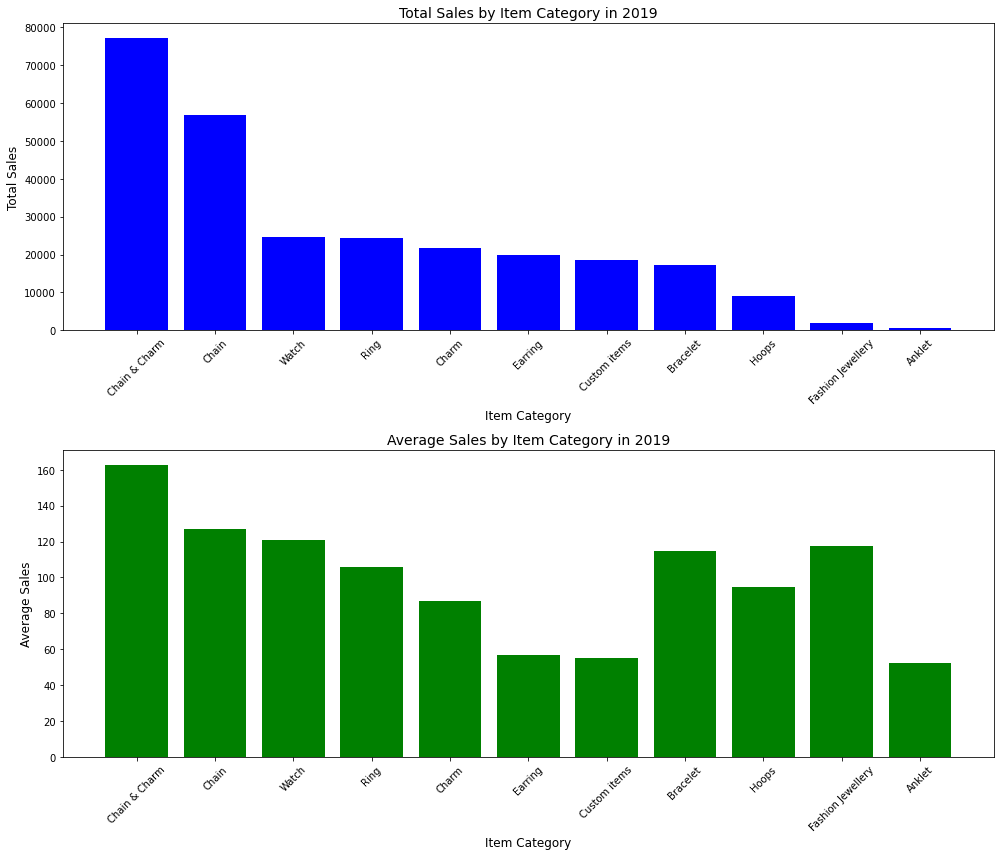

In [17]:
import matplotlib.pyplot as plt

# Filter the dataset for the year 2019
data_2019_filtered = merged_df[merged_df['Date'].dt.year == 2019]

# Group by 'item_category' and calculate the sum and mean of 'total_sale'
category_sales_2019 = data_2019_filtered.groupby('Item Category')['Total Sale'].agg(['sum', 'mean']).reset_index()

# Rename columns for clarity
category_sales_2019.columns = ['Item Category', 'Total Sale', 'Average Sales']

# Sort the data by 'Total Sales' for better visualization
category_sales_2019_sorted = category_sales_2019.sort_values(by='Total Sale', ascending=False)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Bar plot for total sales
ax[0].bar(category_sales_2019_sorted['Item Category'], category_sales_2019_sorted['Total Sale'], color='blue')
ax[0].set_title('Total Sales by Item Category in 2019', fontsize=14)
ax[0].set_xlabel('Item Category', fontsize=12)
ax[0].set_ylabel('Total Sales', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)

# Bar plot for average sales
ax[1].bar(category_sales_2019_sorted['Item Category'], category_sales_2019_sorted['Average Sales'], color='green')
ax[1].set_title('Average Sales by Item Category in 2019', fontsize=14)
ax[1].set_xlabel('Item Category', fontsize=12)
ax[1].set_ylabel('Average Sales', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()


# 2. Total and Average Sales for 2019 : Material Category

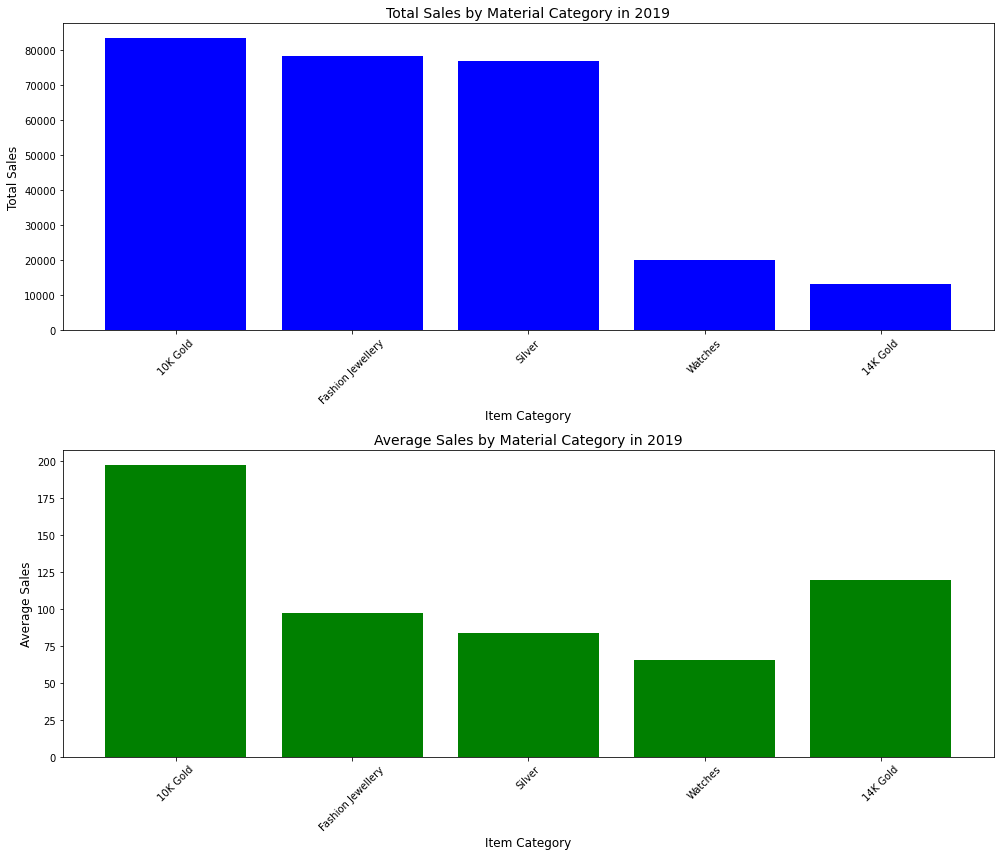

In [18]:
import matplotlib.pyplot as plt

# Filter the dataset for the year 2019
data_2019_filtered = merged_df[merged_df['Date'].dt.year == 2019]

# Group by 'item_category' and calculate the sum and mean of 'total_sale'
Material_sales_2019 = data_2019_filtered.groupby('Material Category')['Total Sale'].agg(['sum', 'mean']).reset_index()

# Rename columns for clarity
Material_sales_2019.columns = ['Material Category', 'Total Sale', 'Average Sales']

# Sort the data by 'Total Sales' for better visualization
Material_sales_2019_sorted = Material_sales_2019.sort_values(by='Total Sale', ascending=False)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Bar plot for total sales
ax[0].bar(Material_sales_2019_sorted['Material Category'], Material_sales_2019_sorted['Total Sale'], color='blue')
ax[0].set_title('Total Sales by Material Category in 2019', fontsize=14)
ax[0].set_xlabel('Item Category', fontsize=12)
ax[0].set_ylabel('Total Sales', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)

# Bar plot for average sales
ax[1].bar(Material_sales_2019_sorted['Material Category'], Material_sales_2019_sorted['Average Sales'], color='green')
ax[1].set_title('Average Sales by Material Category in 2019', fontsize=14)
ax[1].set_xlabel('Item Category', fontsize=12)
ax[1].set_ylabel('Average Sales', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()


# 3.Total Sales by Item Category from 2019 to 2023

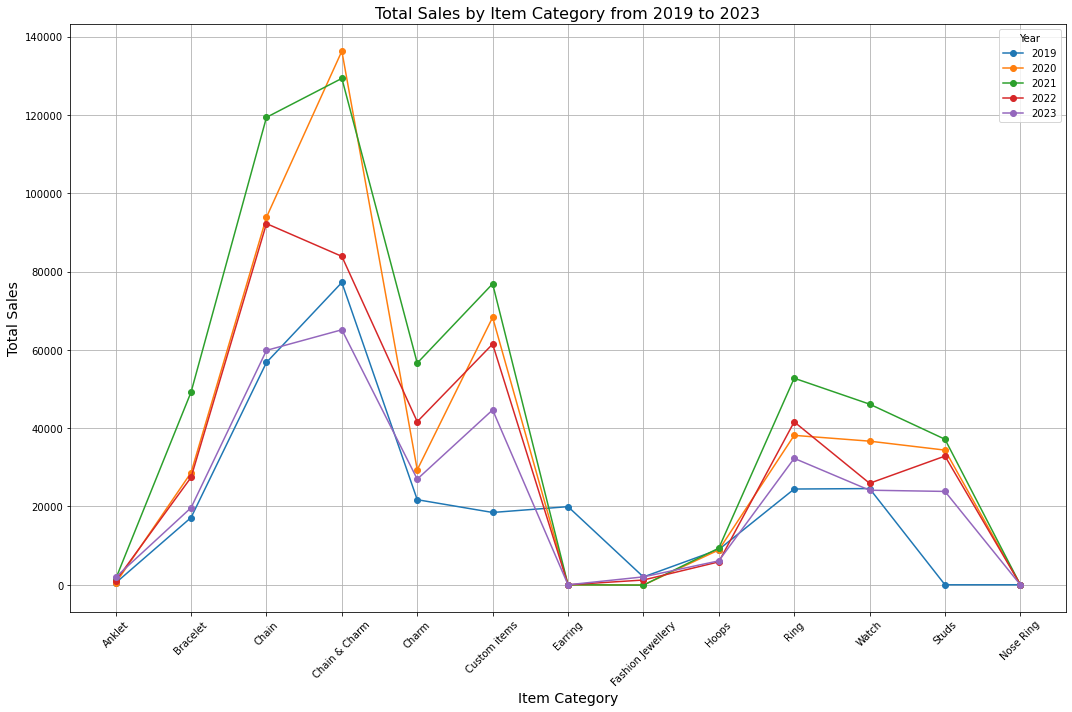

In [19]:
# Filter the dataset for each year from 2019 to 2023 and calculate total sales per item category
years = [2019, 2020, 2021, 2022, 2023]
sales_data = []

for year in years:
    filtered_data = merged_df[merged_df['Date'].dt.year == year]
    sales_summary = filtered_data.groupby('Item Category')['Total Sale'].sum().reset_index()
    sales_summary.columns = ['Item Category', f'Total Sales {year}']
    sales_data.append(sales_summary.set_index('Item Category'))

# Combine the yearly data into a single DataFrame
combined_sales_data = pd.concat(sales_data, axis=1)
combined_sales_data.fillna(0, inplace=True)  # Replace NaNs with 0s for years without sales data

# Plotting
plt.figure(figsize=(15, 10))
for year in years:
    plt.plot(combined_sales_data.index, combined_sales_data[f'Total Sales {year}'], marker='o', label=f'{year}')

plt.title('Total Sales by Item Category from 2019 to 2023', fontsize=16)
plt.xlabel('Item Category', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4.Total Sales by Item Category for December from 2019 to 2023

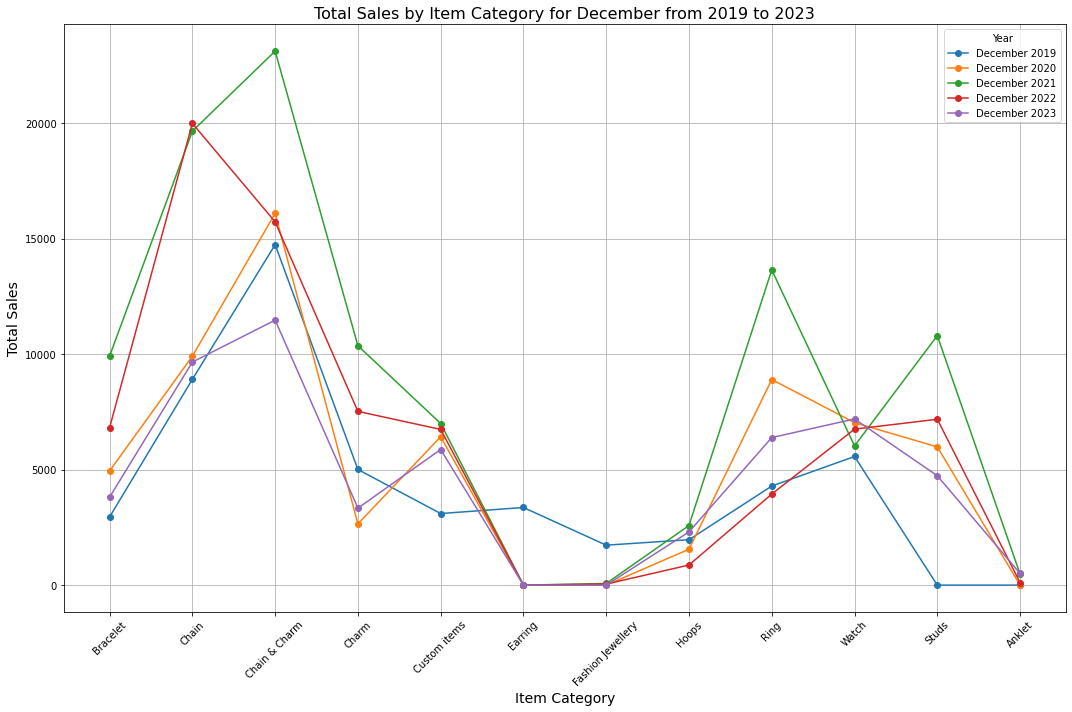

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # For easy access to color palettes

# Assuming merged_df is defined and loaded with the required 'Date' and other columns

# Define the color palette with enough colors
colors = sns.color_palette('tab10', len(years))  # 'tab10' provides 10 distinct colors

# The rest of your code for data filtering
december_sales_data = []
years = range(2019, 2024)  # Ensure 'years' is defined

for year in years:
    december_data = merged_df[(merged_df['Date'].dt.year == year) & (merged_df['Date'].dt.month == 12)]
    december_sales_summary = december_data.groupby('Item Category')['Total Sale'].sum().reset_index()
    december_sales_summary.columns = ['Item Category', f'Total Sales December {year}']
    december_sales_data.append(december_sales_summary.set_index('Item Category'))

# Combine the yearly December data into a single DataFrame
combined_december_sales_data = pd.concat(december_sales_data, axis=1)
combined_december_sales_data.fillna(0, inplace=True)  # Replace NaNs with 0s for years without sales data

# Plotting December sales data
plt.figure(figsize=(15, 10))
for index, year in enumerate(years):
    plt.plot(combined_december_sales_data.index, combined_december_sales_data[f'Total Sales December {year}'],
             marker='o', label=f'December {year}', color=colors[index])

plt.title('Total Sales by Item Category for December from 2019 to 2023', fontsize=16)
plt.xlabel('Item Category', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


## 5.Seasonal Decomposition of Total Sale

In [21]:
# Set 'Date' column as the index
merged_df.set_index('Date', inplace=True)

# Convert 'Total Sale' column to numeric type
merged_df['Total Sale'] = pd.to_numeric(merged_df['Total Sale'], errors='coerce')

# Resample the data on a daily frequency and sum the 'Total Sale' column
merged_data = merged_df['Total Sale'].resample('D').sum().fillna(0)
merged_data.head()

Date
2019-02-01    1171.20
2019-02-02    2617.47
2019-02-03     502.03
2019-02-04    1565.09
2019-02-05     109.00
Name: Total Sale, dtype: float64

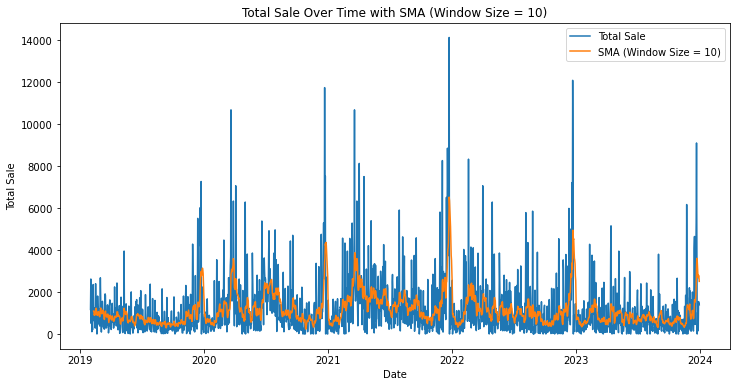

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert pandas Series to DataFrame
merged_data_df = merged_data.reset_index()

# Calculate the simple moving average with a window size of 10
merged_data_df['SMA_10'] = merged_data_df['Total Sale'].rolling(window=10).mean()

# Visualize sales trend over time with SMA
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Total Sale', data=merged_data_df, label='Total Sale')
sns.lineplot(x='Date', y='SMA_10', data=merged_data_df, label='SMA (Window Size = 10)')
plt.title('Total Sale Over Time with SMA (Window Size = 10)')
plt.xlabel('Date')
plt.ylabel('Total Sale')
plt.legend()
plt.show()


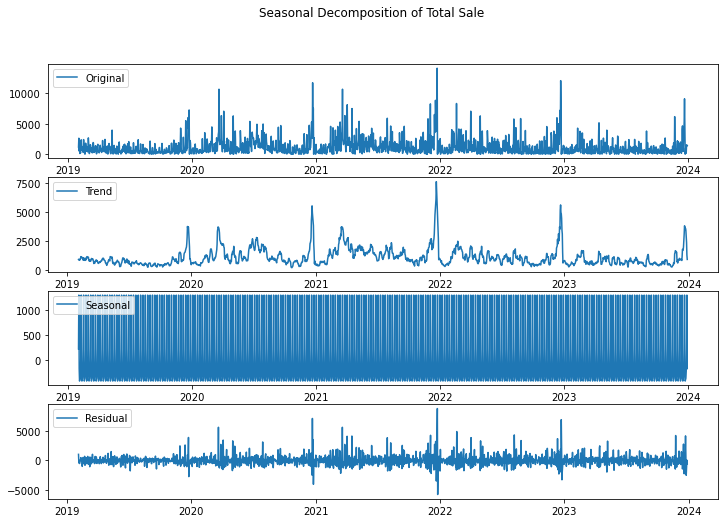

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming merged_data_df is already defined with appropriate columns and datetime index
merged_data_df.set_index('Date', inplace=True)

# Apply seasonal decomposition
result = seasonal_decompose(merged_data_df['Total Sale'], model='additive')

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(merged_data_df.index, merged_data_df['Total Sale'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(merged_data_df.index, result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(merged_data_df.index, result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(merged_data_df.index, result.resid, label='Residual')
plt.legend(loc='upper left')

plt.suptitle('Seasonal Decomposition of Total Sale')
plt.show()


# 6.Average Sales by Day of the Week

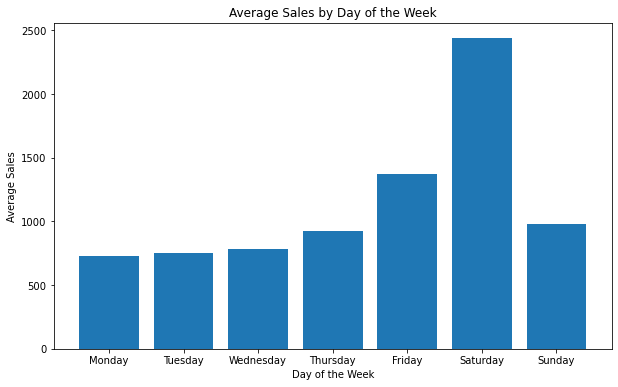

In [24]:
# Resample the data on a daily frequency and sum the 'Total Sale' column
daily_sales = merged_data.resample('D').sum().fillna(0)

monthly_sales = merged_data.resample('M').sum().fillna(0)

# Group the data by day of the week and take the average
average_sales_by_day = daily_sales.groupby(daily_sales.index.dayofweek).mean()

# Map day of week numbers to corresponding day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot average sales by day of the week
plt.figure(figsize=(10, 6))
plt.bar(day_names, average_sales_by_day)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.show()

# 7. Average Total Sale by Day of Month

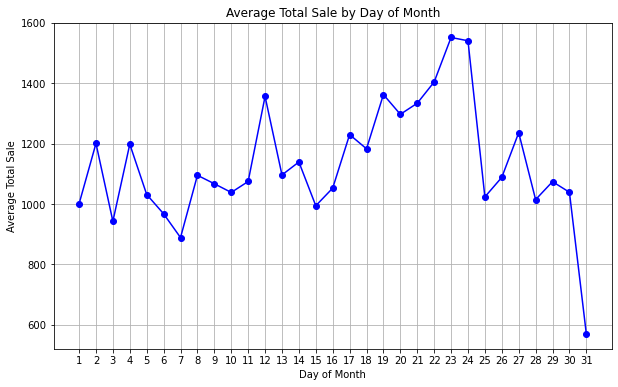

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Take average of 'Total Sale' on the 1st, 2nd, 3rd, ..., 31st of every month
averages_by_day_of_month = merged_data.groupby(merged_data.index.day).mean()

# Plot the averages
plt.figure(figsize=(10, 6))
averages_by_day_of_month.plot(kind='line', marker='o', color='b')
plt.title('Average Total Sale by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average Total Sale')
plt.xticks(range(1, 32))  # Set ticks for each day of the month
plt.grid(True)
plt.show()

# 8.Division of Clusters

In [26]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Create 'Combined Category' if it doesn't already exist in 'combined_df'
merged_df['Combined Category'] = merged_df['Item Category'] + ' - ' + merged_df['Material Category']

# Create a new feature 'Sale Count' which counts the number of sales per 'Combined Category'
sale_count = merged_df['Combined Category'].value_counts().rename('Sale Count')
merged_df = merged_df.merge(sale_count, left_on='Combined Category', right_index=True)

# Now 'Sale Count' is part of your dataframe and can be used as a feature in clustering
numerical_features = ['Cost Price', 'Total Sale', 'age', 'satisfaction_rating', 'Sale Count']  # Added 'Sale Count'
categorical_features = ['Combined Category', 'visit_frequency', 'gender']

# Check for any missing values in the categorical features and fill them with 'Unknown'
merged_df[categorical_features] = merged_df[categorical_features].fillna('Unknown')

# Check for any missing values in the numerical features and fill them with the mean
for feature in numerical_features:
    if merged_df[feature].isnull().any():
        # Convert to float to handle NaN values
        merged_df[feature] = merged_df[feature].astype(float)
        # Now fill NaN values with mean
        merged_df[feature] = merged_df[feature].fillna(merged_df[feature].mean())


# Data preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale data
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# KMeans clustering
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=3, random_state=42))
])

# Fit model
model.fit(merged_df)

quantiles = merged_df['Sale Count'].quantile([0.33, 0.66])

# Function to assign cluster based on sale count
def assign_cluster(sale_count):
    if sale_count >= quantiles[0.66]:
        return 'Most Selling'
    elif sale_count >= quantiles[0.33]:
        return 'Average Selling'
    else:
        return 'Low Selling'

# Create a new column 'Sale Cluster' based on 'Sale Count'
merged_df['Sale Cluster'] = merged_df['Sale Count'].apply(assign_cluster)

# Check the resulting dataframe
merged_df

,Item Category,Material Category,Cost Price,Credit,Total Sale,gender,age,visit_frequency,satisfaction_rating,Combined Category,Sale Count,Sale Cluster
Date,,,,,,,,,,,,
2019-02-01,Chain & Charm,Silver,34,120.00,120.00,Male,62.0,Occasional,3.7,Chain & Charm - Silver,967,Most Selling
2019-02-04,Chain & Charm,Silver,36,212.00,212.00,Male,59.0,Regular,4.4,Chain & Charm - Silver,967,Most Selling
2019-02-04,Chain & Charm,Silver,36,95.39,95.39,Male,39.0,Regular,3.9,Chain & Charm - Silver,967,Most Selling
2019-02-08,Chain & Charm,Silver,0,147.00,147.00,Female,46.0,Regular,4.4,Chain & Charm - Silver,967,Most Selling
2019-02-09,Chain & Charm,Silver,40,111.30,111.30,Male,67.0,Occasional,4.9,Chain & Charm - Silver,967,Most Selling
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,Anklet,10K Gold,54.4,164.30,164.30,Female,46.0,Regular,4.4,Anklet - 10K Gold,11,Low Selling
2023-02-10,Anklet,10K Gold,30.0,85.00,85.00,Female,40.0,Occasional,3.4,Anklet - 10K Gold,11,Low Selling
2023-02-11,Anklet,10K Gold,28.8,63.60,63.60,Male,26.0,Regular,4.4,Anklet - 10K Gold,11,Low Selling


In [27]:
# Group items by category and cluster
item_groups = merged_df.groupby(['Combined Category', 'Sale Cluster']).size().reset_index(name='Count')
item_groups

,Combined Category,Sale Cluster,Count
0,Anklet - 10K Gold,Low Selling,11
1,Anklet - 14K Gold,Low Selling,3
2,Anklet - Fashion Jewellery,Low Selling,3
3,Anklet - Silver,Low Selling,44
4,Bracelet - 10K Gold,Low Selling,247
...,...,...,...
60,Watch - 10K Gold,Low Selling,4
61,Watch - Fashion Jewellery,Low Selling,343
62,Watch - Silver,Low Selling,3
63,Watch - St. Steel,Low Selling,6


In [28]:
item_groups['Combined Category'].nunique()

65

In [29]:
item_groups['Combined Category'].unique()

array(['Anklet - 10K Gold', 'Anklet - 14K Gold',
       'Anklet - Fashion Jewellery', 'Anklet - Silver',
       'Bracelet - 10K Gold', 'Bracelet - 14K Gold',
       'Bracelet - Fashion Jewellery', 'Bracelet - Silver',
       'Bracelet - St. Steel', 'Bracelet - Tungsten',
       'Bracelet - Watches', 'Chain & Charm - 10K Gold',
       'Chain & Charm - 14K Gold', 'Chain & Charm - Fashion Jewellery',
       'Chain & Charm - Silver', 'Chain & Charm - St. Steel',
       'Chain & Charm - Watches', 'Chain - 10K Gold', 'Chain - 14K Gold',
       'Chain - Fashion Jewellery', 'Chain - Silver', 'Chain - St. Steel',
       'Chain - Watches', 'Charm - 10K Gold', 'Charm - 14K Gold',
       'Charm - Fashion Jewellery', 'Charm - Silver', 'Charm - St. Steel',
       'Custom items - 10K Gold', 'Custom items - 14K Gold',
       'Custom items - Fashion Jewellery', 'Custom items - Silver',
       'Custom items - St. Steel', 'Custom items - Tungsten',
       'Custom items - Watches', 'Earring - 10K Gold',
 

In [30]:
item_groups['Sale Cluster'].value_counts()

Low Selling        52
Average Selling     8
Most Selling        5
Name: Sale Cluster, dtype: int64

# 9.Overall Distribution

Index(['Combined Category', 'Sale Cluster', 'Count'], dtype='object')
['Low Selling' 'Most Selling' 'Average Selling']


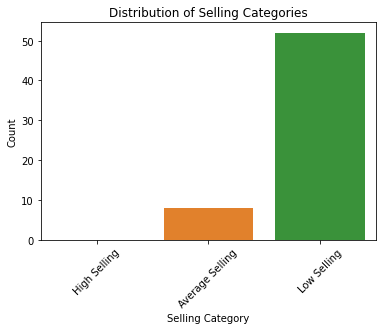

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'item_groups' is your DataFrame and it has been loaded properly
# df = pd.read_csv('path_to_your_file.csv')  # Uncomment this line if you're reading from a CSV file

# Make sure the column names are as expected
print(item_groups.columns)

# Check unique values in the 'Sale Cluster' column to ensure plotting categories correctly
print(item_groups['Sale Cluster'].unique())

# Create a count plot to show the distribution of selling categories
sns.countplot(data=item_groups, x='Sale Cluster', order=['High Selling', 'Average Selling', 'Low Selling'])
plt.title('Distribution of Selling Categories')
plt.xlabel('Selling Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Optional: Rotate labels if they overlap or for better readability
plt.show()


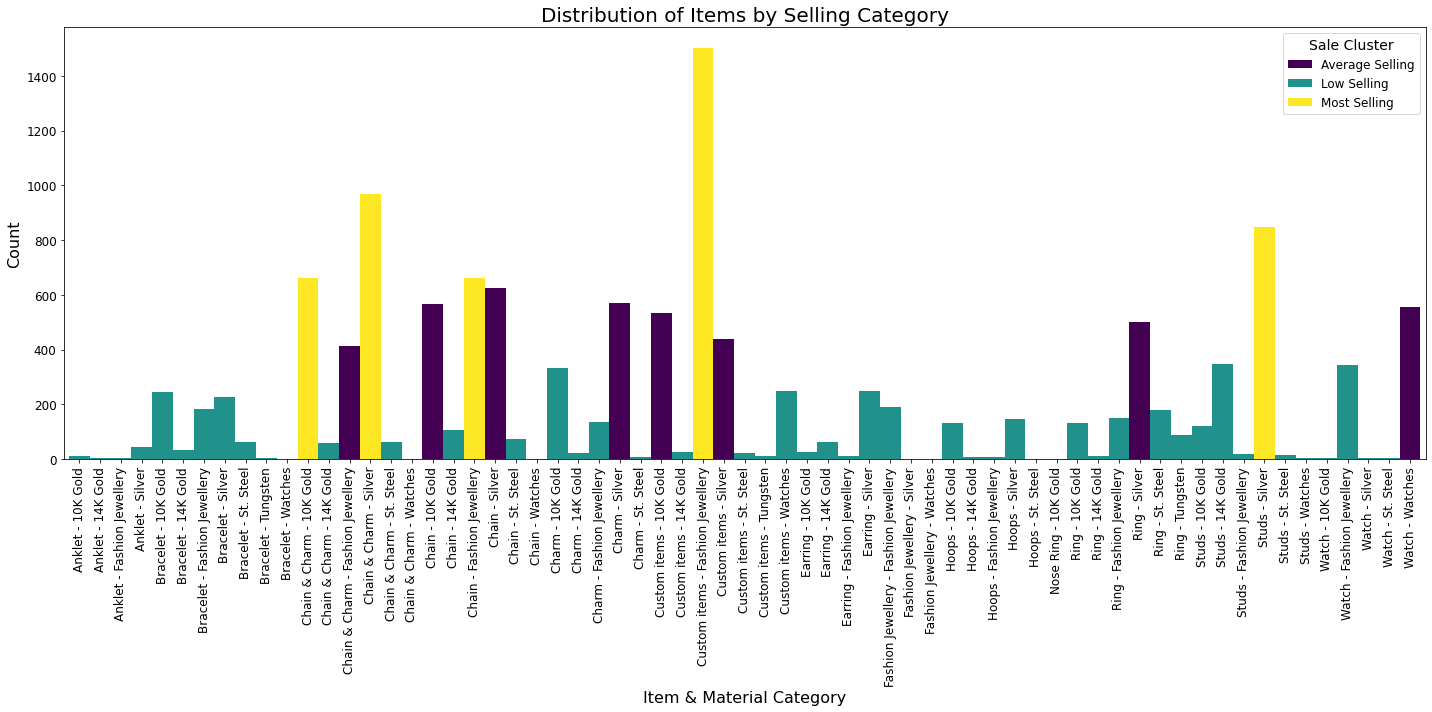

In [32]:
import seaborn as sns

# Aggregating data
agg_data = item_groups.groupby(['Combined Category', 'Sale Cluster'])['Count'].sum().reset_index()

# Pivot the data for visualization
pivot_data = agg_data.pivot_table(index=['Combined Category'], columns='Sale Cluster', values='Count', fill_value=0)

# Assuming your pivot_data is correctly prepared as before
fig, ax = plt.subplots(figsize=(20, 10))
pivot_data.plot(kind='bar', stacked=True, width=1, ax=ax, colormap='viridis')
plt.title('Distribution of Items by Selling Category', fontsize=20)
plt.xlabel('Item & Material Category', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=90, fontsize=12)  # Rotate labels for better readability
plt.yticks(fontsize=12)
plt.legend(title='Sale Cluster', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

In [33]:
merged_df

,Item Category,Material Category,Cost Price,Credit,Total Sale,gender,age,visit_frequency,satisfaction_rating,Combined Category,Sale Count,Sale Cluster
Date,,,,,,,,,,,,
2019-02-01,Chain & Charm,Silver,34,120.00,120.00,Male,62.0,Occasional,3.7,Chain & Charm - Silver,967,Most Selling
2019-02-04,Chain & Charm,Silver,36,212.00,212.00,Male,59.0,Regular,4.4,Chain & Charm - Silver,967,Most Selling
2019-02-04,Chain & Charm,Silver,36,95.39,95.39,Male,39.0,Regular,3.9,Chain & Charm - Silver,967,Most Selling
2019-02-08,Chain & Charm,Silver,0,147.00,147.00,Female,46.0,Regular,4.4,Chain & Charm - Silver,967,Most Selling
2019-02-09,Chain & Charm,Silver,40,111.30,111.30,Male,67.0,Occasional,4.9,Chain & Charm - Silver,967,Most Selling
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,Anklet,10K Gold,54.4,164.30,164.30,Female,46.0,Regular,4.4,Anklet - 10K Gold,11,Low Selling
2023-02-10,Anklet,10K Gold,30.0,85.00,85.00,Female,40.0,Occasional,3.4,Anklet - 10K Gold,11,Low Selling
2023-02-11,Anklet,10K Gold,28.8,63.60,63.60,Male,26.0,Regular,4.4,Anklet - 10K Gold,11,Low Selling


# 10. Top 10 Item Categories and Material Categories

Top 10 Item Categories:
    Item Category  Sale Count
5    Custom items     2798521
3   Chain & Charm     1553518
2           Chain     1166219
11          Studs      853970
4           Charm      453705
12          Watch      426846
10           Ring      332368
1        Bracelet      151011
6         Earring       67298
8           Hoops       38563

Top 10 Material Categories:
   Material Category  Sale Count
2  Fashion Jewellery     3093972
3             Silver     2951082
0           10K Gold     1267178
6            Watches      371662
1           14K Gold      142711
4          St. Steel       46630
5           Tungsten        7729


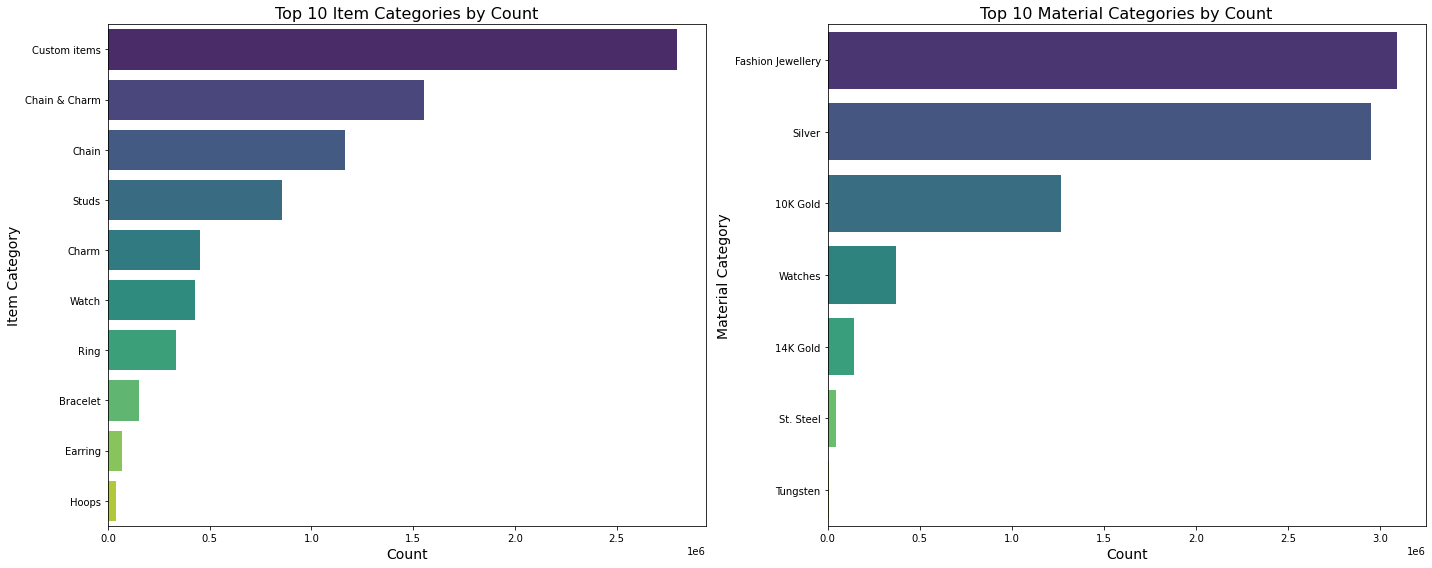

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# If 'Combined Category' needs to be split, uncomment the following lines:
# agg_data[['Item Category', 'Material Category']] = agg_data['Combined Category'].str.split(' - ', expand=True)

# Now, aggregate data to sum counts for each Item Category and Material Category
item_category_sum = merged_df.groupby('Item Category')['Sale Count'].sum().reset_index()
material_category_sum = merged_df.groupby('Material Category')['Sale Count'].sum().reset_index()

# Sort and select the top 10 for each category
top_10_items = item_category_sum.sort_values(by='Sale Count', ascending=False).head(10)
top_10_materials = material_category_sum.sort_values(by='Sale Count', ascending=False).head(10)

# Display the results
print("Top 10 Item Categories:")
print(top_10_items)
print("\nTop 10 Material Categories:")
print(top_10_materials)

# Optionally, plot the results for visual representation
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Bar plot for Top 10 Item Categories
sns.barplot(x='Sale Count', y='Item Category', data=top_10_items, ax=axs[0], palette='viridis')
axs[0].set_title('Top 10 Item Categories by Count', fontsize=16)
axs[0].set_xlabel('Count', fontsize=14)
axs[0].set_ylabel('Item Category', fontsize=14)

# Bar plot for Top 10 Material Categories
sns.barplot(x='Sale Count', y='Material Category', data=top_10_materials, ax=axs[1], palette='viridis')
axs[1].set_title('Top 10 Material Categories by Count', fontsize=16)
axs[1].set_xlabel('Count', fontsize=14)
axs[1].set_ylabel('Material Category', fontsize=14)

plt.tight_layout()
plt.show()


# Modelling: Time Series Models

# 1.SARIMA Model: predictions for 2024 year

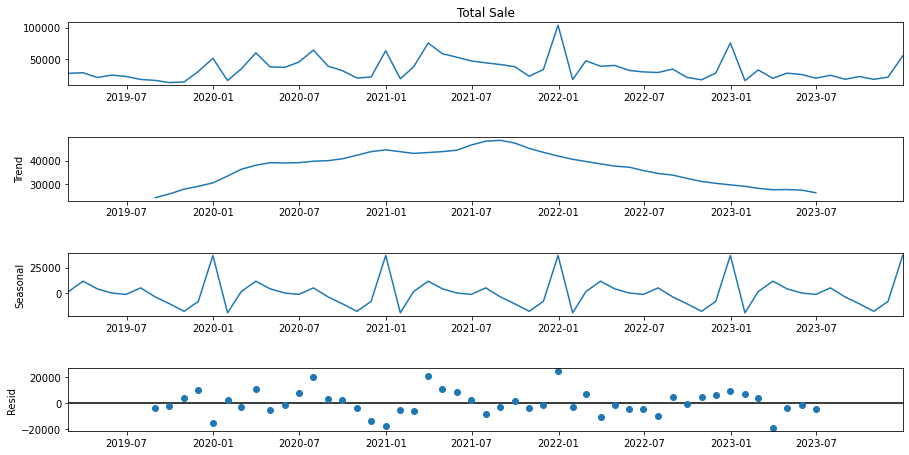

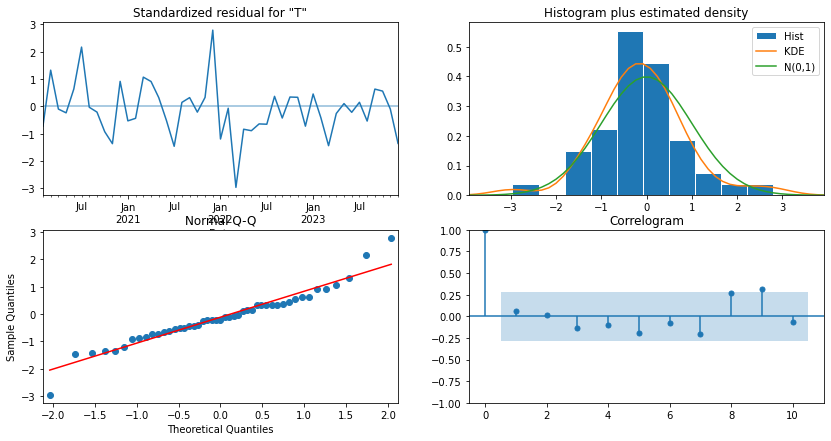

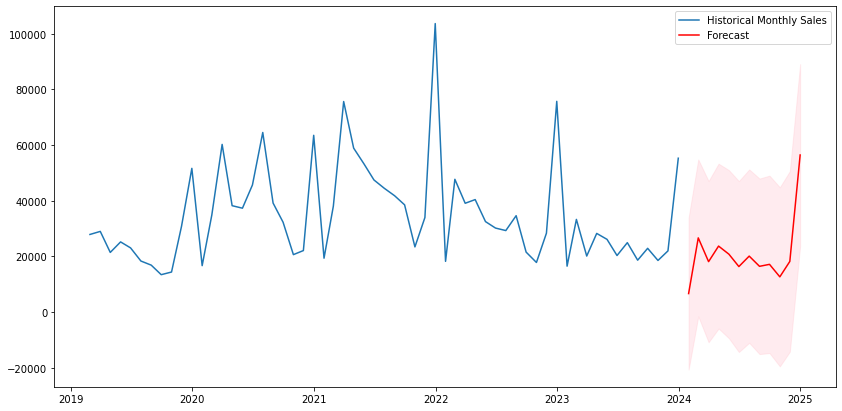

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'monthly_sales' is a pandas Series with the sales data and 'Date' as a DateTimeIndex
# Resample the data on a daily frequency and sum the 'Total Sale' column
#daily_sales = merged_data.resample('D').sum().fillna(0)

#monthly_sales = merged_data.resample('M').sum().fillna(0)

# Step1: Seasonal Decomposition
result = seasonal_decompose(monthly_sales, model='additive', period=12)  # Assuming monthly data with yearly seasonality
fig = result.plot()
fig.set_size_inches(14, 7)
plt.show()

# Analyze the decomposed components and observe the seasonality, trend

# Step2: Fit SARIMA Model (SARIMAX)
# Using the SARIMAX class since we have a pandas Series
model_M = SARIMAX(monthly_sales, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
model_fit_M = model_M.fit()

# Step3: Model Diagnostics
model_fit_M.plot_diagnostics(figsize=(14, 7))
plt.show()

# Step4: Forecasting
forecast = model_fit_M.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='M')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


# Step5: Visualizing Predictions
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales, label='Historical Monthly Sales')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


In [36]:
forecast_mean

2024-01-31     6627.551364
2024-02-29    26635.914244
2024-03-31    18095.679159
2024-04-30    23686.737043
2024-05-31    20784.575857
2024-06-30    16332.984726
2024-07-31    20087.570720
2024-08-31    16415.396470
2024-09-30    17129.687973
2024-10-31    12638.465367
2024-11-30    18175.597755
2024-12-31    56416.504750
Freq: M, Name: predicted_mean, dtype: float64

2024-01-01     814.502165
2024-01-02     829.254700
2024-01-03     851.980405
2024-01-04     987.266435
2024-01-05    1418.203194
                 ...     
2024-12-27    1355.912175
2024-12-28    2412.269240
2024-12-29     967.076990
2024-12-30     721.211132
2024-12-31     744.942375
Freq: D, Name: predicted_mean, Length: 366, dtype: float64


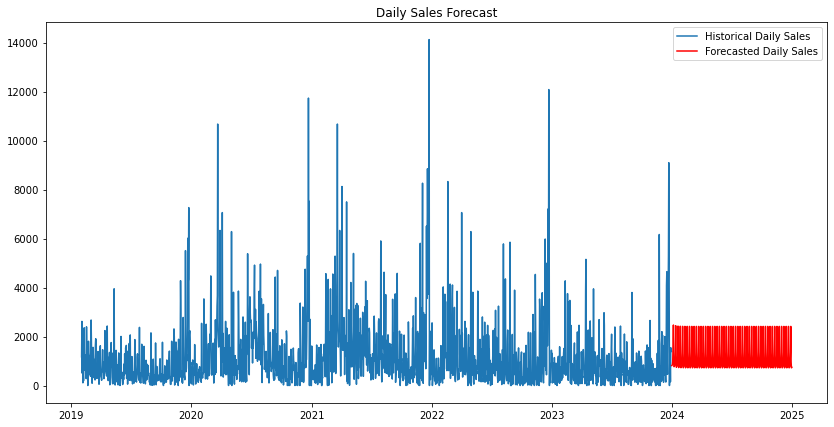

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Assuming 'daily_sales' is your pandas Series with the sales data indexed by date
# Ensure daily_sales index is in proper datetime format
daily_sales.index = pd.to_datetime(daily_sales.index)

# Fit the model on daily sales data
# Adjust the order and seasonal_order as needed based on your specific data
model_d = SARIMAX(daily_sales, order=(1, 0, 1), seasonal_order=(1,0, 1, 7))  # Example: weekly seasonality
model_fit_d = model_d.fit(disp=False)

# Generate a forecast index starting the day after the last date in your series
forecast_index1 = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=366, freq='D')

# Forecast for the next 366 days
forecast1 = model_fit_d.get_forecast(steps=366)
forecast_mean1 = forecast1.predicted_mean

# Print the forecast mean
print(forecast_mean1)

# Optionally, plot the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(daily_sales, label='Historical Daily Sales')
plt.plot(forecast_index1, forecast_mean1, label='Forecasted Daily Sales', color='red')
plt.legend()
plt.title('Daily Sales Forecast')
plt.show()

In [38]:
# Create a DataFrame from the forecasted mean with dates as the index
forecast_df = pd.DataFrame({
    'Forecasted Sales': forecast_mean1
}, index=forecast_index1)

# Check the DataFrame
print(forecast_df.head())


            Forecasted Sales
2024-01-01        814.502165
2024-01-02        829.254700
2024-01-03        851.980405
2024-01-04        987.266435
2024-01-05       1418.203194


In [39]:
# Resample the forecast data to monthly, summing daily sales to monthly sales
monthly_forecast = forecast_df.resample('M').sum()

# Print the monthly forecast data to ensure it's calculated correctly
print(monthly_forecast)

            Forecasted Sales
2024-01-31      34753.115569
2024-02-29      32543.068239
2024-03-31      36322.437937
2024-04-30      33050.792002
2024-05-31      34634.466494
2024-06-30      34963.464896
2024-07-31      33825.726379
2024-08-31      36270.170211
2024-09-30      33271.516821
2024-10-31      34022.095629
2024-11-30      35350.904878
2024-12-31      34015.667571


# Considering 2023 as actual values: To check R2 value of model 

In [40]:
# Splitting the data into training and testing sets
train_data = monthly_sales[:'2022']
test_data = monthly_sales['2023']

# Check if your test data covers all of 2023 or adjust accordingly
print(test_data)

Date
2023-01-31    16476.12
2023-02-28    33271.34
2023-03-31    20106.95
2023-04-30    28240.65
2023-05-31    26105.40
2023-06-30    20298.31
2023-07-31    24922.53
2023-08-31    18625.66
2023-09-30    22884.79
2023-10-31    18526.94
2023-11-30    21963.38
2023-12-31    55261.76
Freq: M, Name: Total Sale, dtype: float64


In [41]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA Model (SARIMAX)
#model = SARIMAX(train_data, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
#model_fit = model.fit()

In [42]:
# Forecasting
forecast = model_fit_M.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# You can also get confidence intervals for the forecasts
forecast_ci = forecast.conf_int()

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate MSE
mse = mean_squared_error(test_data, forecast_mean)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 26798303.796600904
Root Mean Squared Error (RMSE): 5176.707814489911


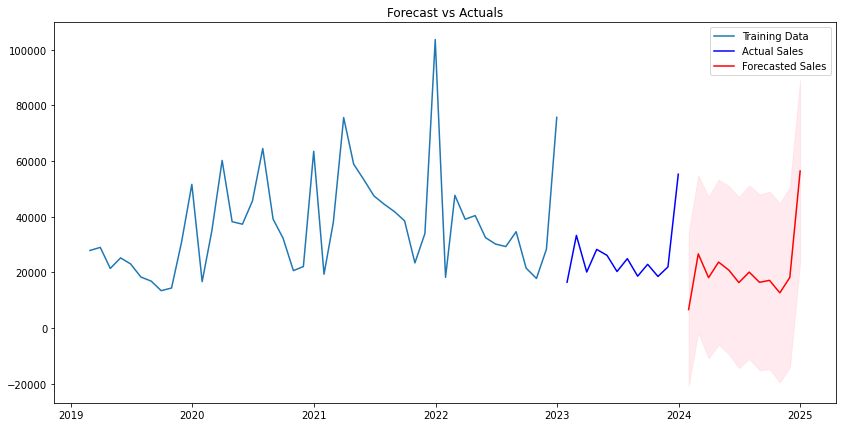

In [44]:
import matplotlib.pyplot as plt

# Visualizing Predictions
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Sales', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import r2_score

# Assuming 'forecast_mean' is your predicted values and 'test_data' is your actual values
r_squared = r2_score(test_data, forecast_mean)
print(f"R-squared: {r_squared}")

R-squared: 0.7335994603239728


# Modelling: Machine Learning Models

# preparing data for Modelling :

In [46]:
# Extract day of the week, month, and date of the month from the index
merged_data_df['Day_of_Week'] = merged_data_df.index.dayofweek
merged_data_df['Month'] = merged_data_df.index.month
merged_data_df['Date_of_Month'] = merged_data_df.index.day

# Display the DataFrame with additional columns
print(merged_data_df)

            Total Sale    SMA_10  Day_of_Week  Month  Date_of_Month
Date                                                               
2019-02-01     1171.20       NaN            4      2              1
2019-02-02     2617.47       NaN            5      2              2
2019-02-03      502.03       NaN            6      2              3
2019-02-04     1565.09       NaN            0      2              4
2019-02-05      109.00       NaN            1      2              5
...                ...       ...          ...    ...            ...
2023-12-27     1008.94  2832.428            2     12             27
2023-12-28      153.00  2685.604            3     12             28
2023-12-29     1541.92  2794.351            4     12             29
2023-12-30     1471.10  2720.331            5     12             30
2023-12-31     1392.54  2504.893            6     12             31

[1795 rows x 5 columns]


In [47]:
import pandas as pd

# Apply seasonal lag by adding the value from the same day of the week in the previous week
merged_data_df['Seasonal Lag'] = merged_data_df['Total Sale'].shift(7, freq='D')

# Apply rolling lag by using rolling mean with a window size of 7
merged_data_df['Rolling Lag'] = merged_data_df['Total Sale'].rolling(window=7).mean()

# Display the DataFrame with lag features
print(merged_data_df)

            Total Sale    SMA_10  Day_of_Week  Month  Date_of_Month  \
Date                                                                  
2019-02-01     1171.20       NaN            4      2              1   
2019-02-02     2617.47       NaN            5      2              2   
2019-02-03      502.03       NaN            6      2              3   
2019-02-04     1565.09       NaN            0      2              4   
2019-02-05      109.00       NaN            1      2              5   
...                ...       ...          ...    ...            ...   
2023-12-27     1008.94  2832.428            2     12             27   
2023-12-28      153.00  2685.604            3     12             28   
2023-12-29     1541.92  2794.351            4     12             29   
2023-12-30     1471.10  2720.331            5     12             30   
2023-12-31     1392.54  2504.893            6     12             31   

            Seasonal Lag  Rolling Lag  
Date                                

In [48]:
import numpy as np

# Extract day of the week, month, and date of the month
day_of_week = merged_data_df.index.dayofweek
month = merged_data_df.index.month
date_of_month = merged_data_df.index.day

# Perform sine and cosine transformations
merged_data_df['Day_of_Week_sin'] = np.sin(2 * np.pi * day_of_week / 7)
#merged_data_df['Day_of_Week_cos'] = np.cos(2 * np.pi * day_of_week / 7)
#merged_data_df['Month_sin'] = np.sin(2 * np.pi * month / 12)
#merged_data_df['Month_cos'] = np.cos(2 * np.pi * month / 12)
#merged_data_df['Date_of_Month_sin'] = np.sin(2 * np.pi * date_of_month / 31)
#merged_data_df['Date_of_Month_cos'] = np.cos(2 * np.pi * date_of_month / 31)

# Drop original categorical columns
#merged_data_df.drop(columns=['Day_of_Week', 'Month', 'Date_of_Month'], inplace=True)

# Display the DataFrame with encoded cyclical variables
print(merged_data_df)

            Total Sale    SMA_10  Day_of_Week  Month  Date_of_Month  \
Date                                                                  
2019-02-01     1171.20       NaN            4      2              1   
2019-02-02     2617.47       NaN            5      2              2   
2019-02-03      502.03       NaN            6      2              3   
2019-02-04     1565.09       NaN            0      2              4   
2019-02-05      109.00       NaN            1      2              5   
...                ...       ...          ...    ...            ...   
2023-12-27     1008.94  2832.428            2     12             27   
2023-12-28      153.00  2685.604            3     12             28   
2023-12-29     1541.92  2794.351            4     12             29   
2023-12-30     1471.10  2720.331            5     12             30   
2023-12-31     1392.54  2504.893            6     12             31   

            Seasonal Lag  Rolling Lag  Day_of_Week_sin  
Date               

# 2.Random forest 

In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Assuming 'merged_data_df' contains both time series data and additional features
endog_column = 'Total Sale'
exog_columns = ['SMA_10','Seasonal Lag', 'Rolling Lag',
                'Day_of_Week','Month','Date_of_Month','Day_of_Week_sin']


# Extract endogenous and exogenous variables
endog = merged_data_df[endog_column]
exog = merged_data_df[exog_columns]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(exog, endog, test_size=0.2, shuffle=False)

# Initialize the model
param_grid = {
    'n_estimators': [7,10],  # Fewer trees
    'max_depth': [3,5,7,9],  # Shallower trees
    'min_samples_split': [13,15,17],  # Higher minimum number of samples to split
    'min_samples_leaf': [7,9,10],  # Higher minimum number of samples at a leaf
    'max_features': [0.4,0.6,0.7],  # Fewer features to use
    'max_leaf_nodes': [40,50,70]  # Restricting the number of leaf nodes
}

# Initialize the RandomForest model
rf_model = RandomForestRegressor(random_state=42)

# Define the K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=False)

# Setup GridSearchCV with K-Fold
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV - This might take some time depending on the size of the data and the complexity of the model setup
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_

# Initialize Random Forest model with best parameters
rf_model_best = RandomForestRegressor(n_estimators=150,max_depth=10,max_features=0.5,random_state=42)

# Fit Random Forest model with best parameters
rf_model_best.fit(X_train, y_train)

# Predict on train set
rf_y_train_pred = rf_model_best.predict(X_train)

# Calculate Mean Squared Error (MSE) on train set
mse_train = mean_squared_error(y_train, rf_y_train_pred)
print("Mean Squared Error (MSE) for train data:", mse_train)

# Calculate Root Mean Squared Error (RMSE) for train data
rmse_train = np.sqrt(mse_train)
print("Root Mean Squared Error (RMSE) for train data:", rmse_train)

# Predict on test set
rf_y_test_pred = rf_model_best.predict(X_test)

# Calculate Mean Squared Error (MSE) on test set
mse_test = mean_squared_error(y_test, rf_y_test_pred)
print("Mean Squared Error (MSE) for test data:", mse_test)

# Calculate Root Mean Squared Error (RMSE) for test data
rmse_test = np.sqrt(mse_test)
print("Root Mean Squared Error (RMSE) for test data:", rmse_test)

# Calculate correlation matrix between actual and predicted values
correlation_matrix = np.corrcoef(y_test, rf_y_test_pred)
print("Correlation Matrix between actual and predicted values:\n", correlation_matrix)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Mean Squared Error (MSE) for train data: 209352.89894665408
Root Mean Squared Error (RMSE) for train data: 457.55097961500866
Mean Squared Error (MSE) for test data: 502262.80232946266
Root Mean Squared Error (RMSE) for test data: 708.705017852606
Correlation Matrix between actual and predicted values:
 [[1.         0.71922008]
 [0.71922008 1.        ]]


In [50]:
best_params

{'max_depth': 7,
 'max_features': 0.6,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 7,
 'min_samples_split': 13,
 'n_estimators': 10}

In [51]:
from sklearn.metrics import r2_score

# Calculate R-squared score for train data
r2_score_train = r2_score(y_train, rf_y_train_pred)
print("R-squared score for train data:", r2_score_train)

# Calculate R-squared score for test data
r2_score_test = r2_score(y_test, rf_y_test_pred)

print("R-squared score for test data:", r2_score_test)

R-squared score for train data: 0.8962084544691392
R-squared score for test data: 0.5161026571954193


In [52]:
# Assuming 'rf_model_best' is your trained Random Forest model
# and 'exog_columns' are the names of your features

# Retrieve the feature importances from the model
feature_importances = rf_model_best.feature_importances_

# Pair each feature with its importance score
features_importance = zip(exog_columns, feature_importances)

# Convert to a list and sort the features by importance
sorted_features_importance = sorted(features_importance, key=lambda x: x[1], reverse=True)

# Optionally, convert to a DataFrame for better visualization
importance_df = pd.DataFrame(sorted_features_importance, columns=['Feature', 'Importance'])

# Display the sorted feature importances
print(importance_df)

           Feature  Importance
0      Rolling Lag    0.330388
1           SMA_10    0.222234
2  Day_of_Week_sin    0.151035
3     Seasonal Lag    0.104469
4    Date_of_Month    0.079177
5      Day_of_Week    0.060387
6            Month    0.052310


In [53]:
columns=['Total Sale','SMA_10','Seasonal Lag','Rolling Lag','Day_of_Week','Month','Day_of_Week_sin']

# Compute the correlation matrix for the specified columns
correlation_matrix = merged_data_df[columns].corr()

# Display the correlation matrix
correlation_matrix

,Total Sale,SMA_10,Seasonal Lag,Rolling Lag,Day_of_Week,Month,Day_of_Week_sin
Total Sale,1.000000,0.513617,0.353792,0.547584,0.247338,0.055997,-0.294699
SMA_10,0.513617,1.000000,0.574895,0.935398,0.072220,0.090960,-0.123672
Seasonal Lag,0.353792,0.574895,1.000000,0.386963,0.246767,0.067117,-0.294612
Rolling Lag,0.547584,0.935398,0.386963,1.000000,-0.000194,0.105743,0.000370
Day_of_Week,0.247338,0.072220,0.246767,-0.000194,1.000000,-0.001779,-0.734592
Month,0.055997,0.090960,0.067117,0.105743,-0.001779,1.000000,0.003733
Day_of_Week_sin,-0.294699,-0.123672,-0.294612,0.000370,-0.734592,0.003733,1.000000


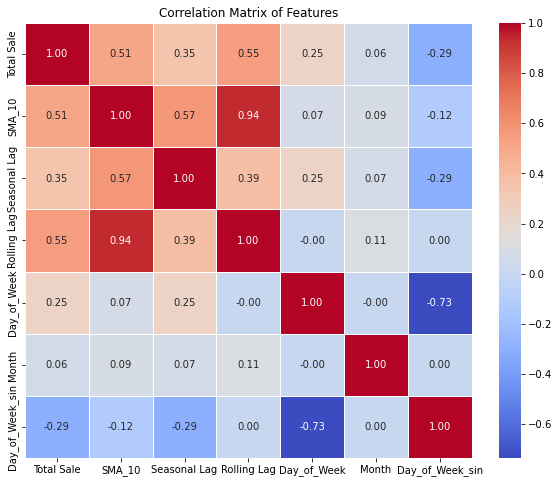

In [54]:
# Optionally, visualize the correlation matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()

# predictions for 2024 using Random Forest

In [55]:
import pandas as pd
import numpy as np

# Ensure 'Date' is the DateTimeIndex
#merged_data_df.set_index('Date', inplace=True)

# Generate the dates for the year 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

# Prepare DataFrame to store forecasted features
forecasted_features_df = pd.DataFrame(index=dates_2024)

# Calculate Day_of_Week, Month, and Date_of_Month for 2024
forecasted_features_df['Day_of_Week'] = forecasted_features_df.index.dayofweek
forecasted_features_df['Month'] = forecasted_features_df.index.month
forecasted_features_df['Date_of_Month'] = forecasted_features_df.index.day

# Calculate Day_of_Week_sin as a cyclic feature
forecasted_features_df['Day_of_Week_sin'] = np.sin(2 * np.pi * forecasted_features_df['Day_of_Week'] / 7)

# Using historical data to calculate SMA_10, Seasonal Lag, and Rolling Lag
# You should adjust these calculations based on the nature of your data and modeling approach
historical_data = merged_data_df['Total Sale'].copy()
historical_data = historical_data.append(pd.Series([np.nan] * len(dates_2024), index=dates_2024))  # Append NaNs for 2024

# Simple Moving Average of the last 10 days
forecasted_features_df['SMA_10'] = historical_data.rolling(window=10).mean().loc[dates_2024]

# Seasonal Lag (last year same day)
forecasted_features_df['Seasonal Lag'] = historical_data.shift(365).loc[dates_2024]

# Rolling Lag (average of the last 7 days)
forecasted_features_df['Rolling Lag'] = historical_data.rolling(window=7).mean().loc[dates_2024]

# Handle missing data if any, especially for early 2024
#forecasted_features_df.fillna(method='ffill', inplace=True)


In [56]:
forecasted_features_df

,Day_of_Week,Month,Date_of_Month,Day_of_Week_sin,SMA_10,Seasonal Lag,Rolling Lag
2024-01-01,0,1,1,0.000000,NaN,949.50,NaN
2024-01-02,1,1,2,0.781831,NaN,1314.44,NaN
2024-01-03,2,1,3,0.974928,NaN,104.00,NaN
2024-01-04,3,1,4,0.433884,NaN,242.00,NaN
2024-01-05,4,1,5,-0.433884,NaN,895.78,NaN
...,...,...,...,...,...,...,...
2024-12-27,4,12,27,-0.433884,NaN,153.00,NaN
2024-12-28,5,12,28,-0.974928,NaN,1541.92,NaN
2024-12-29,6,12,29,-0.781831,NaN,1471.10,NaN
2024-12-30,0,12,30,0.000000,NaN,1392.54,NaN


In [57]:
# Predict using the RandomForest model
predicted_sales_2024 = rf_model_best.predict(forecasted_features_df[['SMA_10', 'Seasonal Lag', 'Rolling Lag', 'Day_of_Week', 'Month', 'Date_of_Month', 'Day_of_Week_sin']])

# Add predictions back to the DataFrame
forecasted_features_df['Predicted Total Sale'] = predicted_sales_2024

# Output the predicted total sales for 2024
print(forecasted_features_df['Predicted Total Sale'])

2024-01-01     781.483846
2024-01-02     642.756541
2024-01-03     611.565703
2024-01-04     827.490815
2024-01-05     941.428917
                 ...     
2024-12-27    1473.025097
2024-12-28    2459.732807
2024-12-29    1058.715320
2024-12-30     881.767258
2024-12-31     628.021760
Freq: D, Name: Predicted Total Sale, Length: 366, dtype: float64


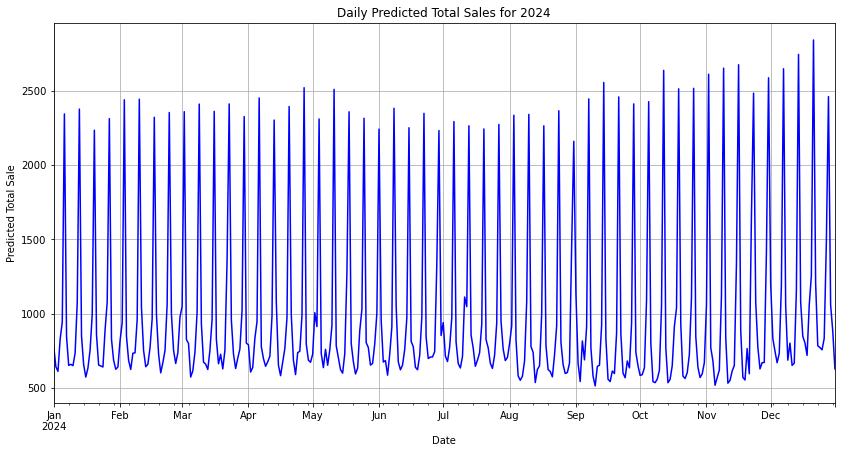

In [58]:
import matplotlib.pyplot as plt

# Assuming 'forecasted_features_df' contains the 'Predicted Total Sale' column with daily forecasts

# Plot daily predicted sales
plt.figure(figsize=(14, 7))
forecasted_features_df['Predicted Total Sale'].plot(title='Daily Predicted Total Sales for 2024', color='blue')
plt.xlabel('Date')
plt.ylabel('Predicted Total Sale')
plt.grid(True)
plt.show()

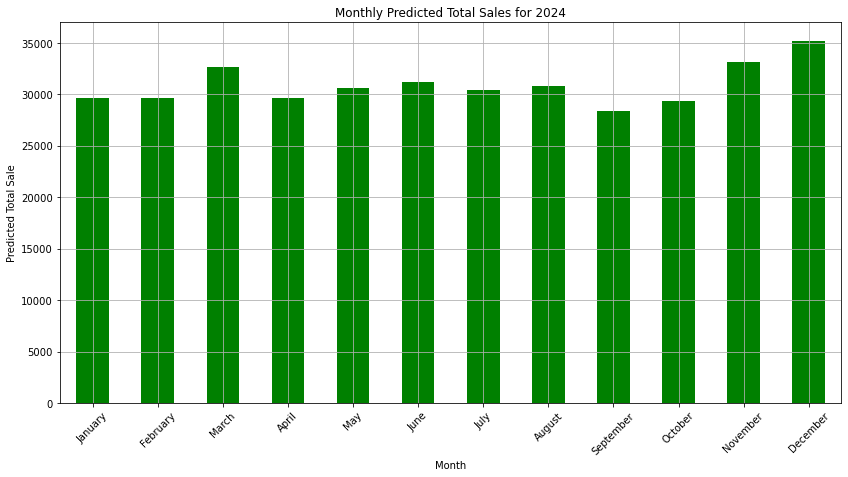

In [59]:
import matplotlib.pyplot as plt

# Aggregate to monthly predicted sales
monthly_sales_2024 = forecasted_features_df['Predicted Total Sale'].resample('M').sum()

# Convert index to month names for clarity
monthly_sales_2024.index = monthly_sales_2024.index.strftime('%B')

# Plot monthly predicted sales
plt.figure(figsize=(14, 7))
monthly_sales_2024.plot(kind='bar', color='green', title='Monthly Predicted Total Sales for 2024')
plt.xlabel('Month')
plt.ylabel('Predicted Total Sale')
plt.xticks(rotation=45)  # Rotate month labels for better readability
plt.grid(True)
plt.show()


# 3. Gradient Boosting Regressor

In [60]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'merged_data_df' contains both time series data and additional features
gb_endog_column = 'Total Sale'
gb_exog_columns = ['SMA_10','Seasonal Lag', 'Rolling Lag',
                'Day_of_Week','Month','Date_of_Month','Day_of_Week_sin']

# Extract endogenous and exogenous variables
gb_endog = merged_data_df[gb_endog_column]
gb_exog = merged_data_df[gb_exog_columns]

# Fill NA values with zero
gb_exog_filled = gb_exog.fillna(0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gb_exog_filled, gb_endog, test_size=0.2, shuffle=False)

# Parameter distribution for randomized search
param_dist1 = {
    'n_estimators': [10, 15, 25, 50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.1, 0.3, 0.5]
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist1, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_

# Initialize Gradient Boosting model with best parameters
best_gbm = GradientBoostingRegressor(random_state=42, **best_params)

# Fit the model with the best parameters
best_gbm.fit(X_train, y_train)

# Predictions
gbm_y_train_pred = best_gbm.predict(X_train)
gbm_y_test_pred = best_gbm.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, gbm_y_train_pred)
test_mse = mean_squared_error(y_test, gbm_y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, gbm_y_train_pred)
test_r2 = r2_score(y_test, gbm_y_test_pred)

# Output the results
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error (MSE) for train data: {train_mse:.3f}")
print(f"Root Mean Squared Error (RMSE) for train data: {train_rmse:.3f}")
print(f"Mean Squared Error (MSE) for test data: {test_mse:.3f}")
print(f"Root Mean Squared Error (RMSE) for test data: {test_rmse:.3f}")
print(f"R-Squared score of Train (R^2 train) : {train_r2:.3f}")
print(f"R-Squared score of Test (R^2 test) : {test_r2:.3f}")

Best Parameters: {'n_estimators': 25, 'max_depth': 4, 'learning_rate': 0.1}
Mean Squared Error (MSE) for train data: 507053.671
Root Mean Squared Error (RMSE) for train data: 712.077
Mean Squared Error (MSE) for test data: 492760.473
Root Mean Squared Error (RMSE) for test data: 701.969
R-Squared score of Train (R^2 train) : 0.749
R-Squared score of Test (R^2 test) : 0.525


# 4. XGBoost model

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Assuming 'model_data' and 'X_train, X_test, y_train, y_test' are already defined

# XGBoost Regressor
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_
xgb_y_train_pred = best_xgb.predict(X_train)
xgb_y_test_pred = best_xgb.predict(X_test)

# Evaluation and Printing results
print("XGBoost - Train R2:", r2_score(y_train, xgb_y_train_pred))
print("XGBoost - Test R2:", r2_score(y_test, xgb_y_test_pred))
print("XGBoost - Train RMSE:", np.sqrt(mean_squared_error(y_train, xgb_y_train_pred)))
print("XGBoost - Test RMSE:", np.sqrt(mean_squared_error(y_test, xgb_y_test_pred)))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
XGBoost - Train R2: 0.853570336884263
XGBoost - Test R2: 0.5142604353099153
XGBoost - Train RMSE: 543.4668164529498
XGBoost - Test RMSE: 710.0527744167169


In [62]:
# Predict using the RandomForest model
predicted_sales_2024 = best_xgb.predict(forecasted_features_df[['SMA_10', 'Seasonal Lag', 'Rolling Lag', 'Day_of_Week', 'Month', 'Date_of_Month', 'Day_of_Week_sin']])

# Add predictions back to the DataFrame
forecasted_features_df['Predicted Total Sale'] = predicted_sales_2024

# Output the predicted total sales for 2024
print(forecasted_features_df['Predicted Total Sale'])

2024-01-01     5276.273926
2024-01-02     5186.795898
2024-01-03     3557.374023
2024-01-04     6246.948730
2024-01-05    10277.649414
                  ...     
2024-12-27     3704.865723
2024-12-28     2275.087158
2024-12-29     2511.906494
2024-12-30     2455.410889
2024-12-31      598.407898
Freq: D, Name: Predicted Total Sale, Length: 366, dtype: float32


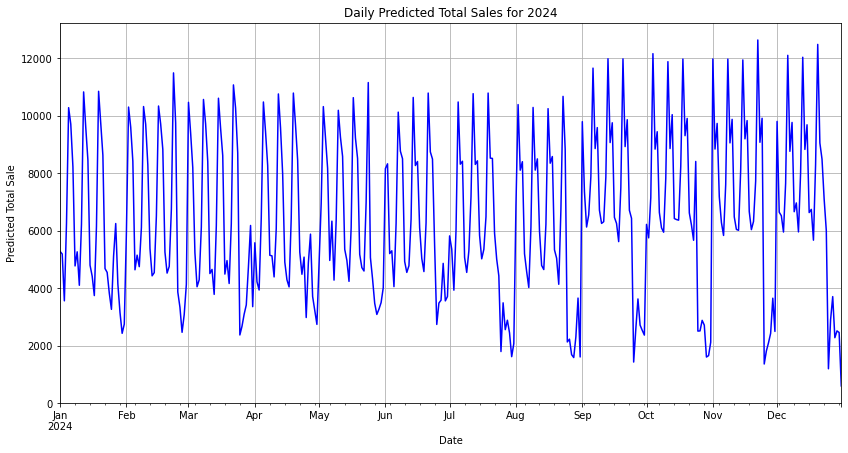

In [63]:
import matplotlib.pyplot as plt

# Assuming 'forecasted_features_df' contains the 'Predicted Total Sale' column with daily forecasts

# Plot daily predicted sales
plt.figure(figsize=(14, 7))
forecasted_features_df['Predicted Total Sale'].plot(title='Daily Predicted Total Sales for 2024', color='blue')
plt.xlabel('Date')
plt.ylabel('Predicted Total Sale')
plt.grid(True)
plt.show()

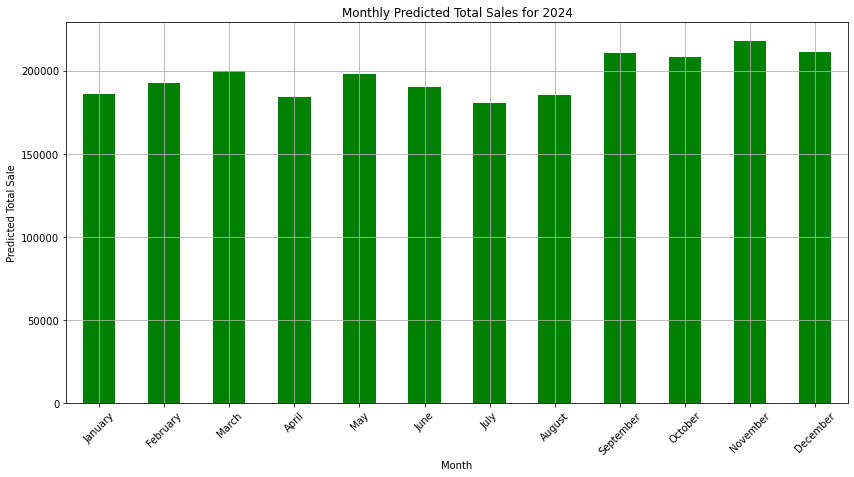

In [64]:
import matplotlib.pyplot as plt

# Aggregate to monthly predicted sales
monthly_sales_2024 = forecasted_features_df['Predicted Total Sale'].resample('M').sum()

# Convert index to month names for clarity
monthly_sales_2024.index = monthly_sales_2024.index.strftime('%B')

# Plot monthly predicted sales
plt.figure(figsize=(14, 7))
monthly_sales_2024.plot(kind='bar', color='green', title='Monthly Predicted Total Sales for 2024')
plt.xlabel('Month')
plt.ylabel('Predicted Total Sale')
plt.xticks(rotation=45)  # Rotate month labels for better readability
plt.grid(True)
plt.show()


# 5.AdaBoost Regressor

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# Assuming 'model_data' and 'X_train, X_test, y_train, y_test' are already defined

# AdaBoost Regressor
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

ada = AdaBoostRegressor(random_state=42)
grid_search_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_ada.fit(X_train, y_train)

best_ada = grid_search_ada.best_estimator_
ada_y_train_pred = best_ada.predict(X_train)
ada_y_test_pred = best_ada.predict(X_test)

# Evaluation and Printing results
print("AdaBoost - Train R2:", r2_score(y_train, ada_y_train_pred))
print("AdaBoost - Test R2:", r2_score(y_test, ada_y_test_pred))
print("AdaBoost - Train RMSE:", np.sqrt(mean_squared_error(y_train, ada_y_train_pred)))
print("AdaBoost - Test RMSE:", np.sqrt(mean_squared_error(y_test, ada_y_test_pred)))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
AdaBoost - Train R2: 0.6245790641489705
AdaBoost - Test R2: 0.34340468780897393
AdaBoost - Train RMSE: 870.197325176744
AdaBoost - Test RMSE: 825.5393477890715


# 6.ENSEMBLING - Simple mean

In [66]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions from the RandomForest model
#rf_y_train_pred = rf_model_best.predict(X_train)
#rf_y_test_pred = rf_model_best.predict(X_test)

# Predictions from the GradientBoosting model
#gbm_y_train_pred = best_gbm.predict(X_train)
#gbm_y_test_pred = best_gbm.predict(X_test)

# Averaging predictions
ensemble_y_train_pred = (rf_y_train_pred + gbm_y_train_pred + xgb_y_train_pred) / 3
ensemble_y_test_pred = (rf_y_test_pred + gbm_y_test_pred + xgb_y_test_pred) / 3

# Evaluation metrics for the ensemble model
ensemble_train_mse = mean_squared_error(y_train, ensemble_y_train_pred)
ensemble_test_mse = mean_squared_error(y_test, ensemble_y_test_pred)
ensemble_train_rmse = np.sqrt(ensemble_train_mse)
ensemble_test_rmse = np.sqrt(ensemble_test_mse)
ensemble_train_r2 = r2_score(y_train, ensemble_y_train_pred)
ensemble_test_r2 = r2_score(y_test, ensemble_y_test_pred)

# Output the ensemble's performance
print("Ensemble Model Performance:")
print(f"Train MSE: {ensemble_train_mse:.3f}")
print(f"Train RMSE: {ensemble_train_rmse:.3f}")

print(f"Test MSE: {ensemble_test_mse:.3f}")
print(f"Test RMSE: {ensemble_test_rmse:.3f}")

print(f"Train R^2: {ensemble_train_r2:.3f}")
print(f"Test R^2: {ensemble_test_r2:.3f}")

Ensemble Model Performance:
Train MSE: 310150.029
Train RMSE: 556.911
Test MSE: 482184.593
Test RMSE: 694.395
Train R^2: 0.846
Test R^2: 0.535


# 7.STACKING

In [67]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the base models
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=150,max_depth=10,max_features=0.5,random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, min_samples_leaf= 2,
    min_samples_split=2, subsample = 0.9, max_depth=5, random_state=42))
]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking ensemble
stacking_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Making predictions
ensemble_y_train_pred = stacking_ensemble.predict(X_train)
ensemble_y_test_pred = stacking_ensemble.predict(X_test)

# Evaluation metrics for the ensemble model
ensemble_train_mse = mean_squared_error(y_train, ensemble_y_train_pred)
ensemble_test_mse = mean_squared_error(y_test, ensemble_y_test_pred)
ensemble_train_rmse = np.sqrt(ensemble_train_mse)
ensemble_test_rmse = np.sqrt(ensemble_test_mse)
ensemble_train_r2 = r2_score(y_train, ensemble_y_train_pred)
ensemble_test_r2 = r2_score(y_test, ensemble_y_test_pred)

# Output the ensemble's performance
print("Stacking Ensemble Model Performance:")
print(f"Train MSE: {ensemble_train_mse:.3f}")
print(f"Train RMSE: {ensemble_train_rmse:.3f}")
print(f"Train R^2: {ensemble_train_r2:.3f}")
print(f"Test MSE: {ensemble_test_mse:.3f}")
print(f"Test RMSE: {ensemble_test_rmse:.3f}")
print(f"Test R^2: {ensemble_test_r2:.3f}")

Stacking Ensemble Model Performance:
Train MSE: 289253.132
Train RMSE: 537.823
Train R^2: 0.857
Test MSE: 493429.200
Test RMSE: 702.445
Test R^2: 0.525


# 8.BAGGING

In [68]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the base classifier
base_rf = RandomForestRegressor(n_estimators=150, max_depth=10, max_features=0.5, random_state=42)

# Create the bagging ensemble
bagging_ensemble = BaggingRegressor(base_rf,
                                    n_estimators=10,  # Number of base estimators
                                    random_state=42, 
                                    bootstrap=True)

# Fit the bagging ensemble
bagging_ensemble.fit(X_train, y_train)

# Making predictions
bagging_y_train_pred = bagging_ensemble.predict(X_train)
bagging_y_test_pred = bagging_ensemble.predict(X_test)

# Evaluation metrics for the bagging model
bagging_train_mse = mean_squared_error(y_train, bagging_y_train_pred)
bagging_test_mse = mean_squared_error(y_test, bagging_y_test_pred)
bagging_train_rmse = np.sqrt(bagging_train_mse)
bagging_test_rmse = np.sqrt(bagging_test_mse)
bagging_train_r2 = r2_score(y_train, bagging_y_train_pred)
bagging_test_r2 = r2_score(y_test, bagging_y_test_pred)

# Output the bagging ensemble's performance
print("Bagging Ensemble Model Performance:")
print(f"Train MSE: {bagging_train_mse:.3f}")
print(f"Train RMSE: {bagging_train_rmse:.3f}")
print(f"Train R^2: {bagging_train_r2:.3f}")
print(f"Test MSE: {bagging_test_mse:.3f}")
print(f"Test RMSE: {bagging_test_rmse:.3f}")
print(f"Test R^2: {bagging_test_r2:.3f}")

Bagging Ensemble Model Performance:
Train MSE: 391120.553
Train RMSE: 625.396
Train R^2: 0.806
Test MSE: 516530.287
Test RMSE: 718.700
Test R^2: 0.502


# Inventory Management 

In [69]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming merged_df is preloaded with your data
# Reset the 'Date' column from the index back to a regular column
df = merged_df.reset_index()

# Rename the former index column if it doesn't automatically have the correct name
df.rename(columns={'index': 'Date'}, inplace=True)

df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month

# Ensure only data from 2019 to 2023 is considered
df = df[df['Year'].between(2019, 2023)]

# Aggregate data monthly within each category
monthly_sales = df.groupby(['Date','Year', 'Month', 'Item Category', 'Material Category']).agg({'Total Sale': 'sum'}).reset_index()

# Pivot the data to have individual columns for each item and material category combination for better feature representation
pivot_item_monthly_sales = monthly_sales.pivot_table(index=['Date'], 
                                                columns=['Item Category'], 
                                                values='Total Sale', 
                                                fill_value=0).reset_index()

pivot_material_monthly_sales = monthly_sales.pivot_table(index=['Date'], 
                                                columns=['Material Category'], 
                                                values='Total Sale', 
                                                fill_value=0).reset_index()


In [70]:
monthly_sales

,Date,Year,Month,Item Category,Material Category,Total Sale
0,2019-02-01,2019.0,2.0,Bracelet,Fashion Jewellery,57.00
1,2019-02-01,2019.0,2.0,Chain & Charm,Silver,120.00
2,2019-02-01,2019.0,2.0,Charm,10K Gold,95.00
3,2019-02-01,2019.0,2.0,Charm,Silver,259.70
4,2019-02-01,2019.0,2.0,Custom items,Fashion Jewellery,344.50
...,...,...,...,...,...,...
9571,2023-12-31,2023.0,12.0,Chain & Charm,10K Gold,300.00
9572,2023-12-31,2023.0,12.0,Chain & Charm,Silver,275.60
9573,2023-12-31,2023.0,12.0,Ring,Silver,130.00
9574,2023-12-31,2023.0,12.0,Studs,14K Gold,266.84


# Model for predicting Material_Categories for 2024 year

In [71]:
pivot_material_monthly_sales

Material Category,Date,10K Gold,14K Gold,Fashion Jewellery,Silver,St. Steel,Tungsten,Watches
0,2019-02-01,95.000,0.00,200.500000,118.675000,0.0,0.00,0.0
1,2019-02-02,286.235,158.30,97.300000,170.806000,0.0,0.00,10.0
2,2019-02-03,107.170,0.00,58.300000,76.463333,0.0,0.00,0.0
3,2019-02-04,627.000,400.00,0.000000,134.522500,0.0,0.00,0.0
4,2019-02-05,0.000,0.00,79.000000,30.000000,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
1747,2023-12-27,337.550,25.00,20.000000,96.280000,0.0,0.00,0.0
1748,2023-12-28,0.000,0.00,0.000000,0.000000,0.0,0.00,153.0
1749,2023-12-29,134.450,94.34,205.333333,144.070000,0.0,115.54,159.0
1750,2023-12-30,156.050,0.00,120.300000,135.580000,159.0,31.80,170.0


In [72]:
pivot_material_monthly_sales.set_index('Date', inplace=True)

# Feature Engineering
pivot_material_monthly_sales['Month'] = pivot_material_monthly_sales.index.month
pivot_material_monthly_sales['Year'] = pivot_material_monthly_sales.index.year
pivot_material_monthly_sales['Day_of_Week'] = pivot_material_monthly_sales.index.dayofweek

# Aggregate total sales for each material category per month
monthly_total_sales = pivot_material_monthly_sales.groupby(['Year', 'Month']).sum()

monthly_total_sales


Material Category      10K Gold     14K Gold  Fashion Jewellery       Silver  \
Year Month                                                                     
2019 2              4229.043333  1493.263333        3211.393333  2965.933500   
     3              5626.615000   897.080000        2786.872476  3287.362333   
     4              5254.436667  1823.000000        2508.144333  2389.655000   
     5              5620.490000  1105.390000        2957.852167  2247.136667   
     6              5543.445833  1092.830000        2801.624000  2409.668833   
     7              4911.446000   949.840000        2640.707500  2402.053333   
     8              2891.430833   522.700000        3358.139667  2085.368000   
     9              1760.030000   244.500000        2045.770833  2225.845000   
     10             1925.863333   156.000000        3113.294000  1725.141333   
     11             4933.145167  1176.220000        2634.395571  3103.653500   
     12             5587.837500  1905.496667        3571.568940  4190.894071   
2020 1              2996.690000   462.690000        2811.941667  2397.246667   
     2              4467.013333  1319.290000        4100.162667  3589.844500   
     3             10077.578333  4767.380000        4260.053333  6049.281333   
     4              9307.489667   544.540000        2309.816667  5018.551667   
     5              9708.580000   837.900000        2765.933333  4147.276667   
     6              7106.380000  3391.840000        3536.158333  6362.110714   
     7             10341.326667  5975.480000        3491.009167  6081.212167   
     8             11191.403333   718.900000        2674.110833  4608.875333   
     9              5203.960000  1719.990000        2128.978333  5137.180833   
     10             6600.426667   420.220000        1132.193333  2692.943333   
     11             5193.013333  1562.195000        1584.150000  2384.800500   
     12             9822.429000  4032.210000        1927.969667  4558.281417   
2021 1              5130.940000  2068.620000        1243.714667  3411.228333   
     2              5973.406667  1385.600000        3435.561667  2980.090000   
     3             15708.825500  4662.735000        2957.759167  5992.915000   
     4             10653.835833  1341.190000        4295.223333  4821.914524   
     5             11638.621667  2300.810000        2691.449333  4264.361833   
     6              7362.945000  1737.300000        4517.009667  4075.775000   
     7             12042.470000  1898.500000        2745.643333  4333.843333   
     8              9692.016667  1693.080000        3211.430500  4928.269167   
     9              8740.586333  2870.900000        1901.688333  3066.523333   
     10             6446.986000   413.000000        2337.533333  3431.010000   
     11             9727.638333  1102.500000        2467.216667  3256.683333   
     12            14602.722143  4197.350000        4027.361667  5293.729000   
2022 1              5522.825000   928.790000        2305.396667  2763.033333   
     2              7864.060000  1620.235000        3303.436667  5132.323619   
     3              8850.796667   615.450000        3142.688333  4724.680000   
     4             10008.551333   743.540000        2395.816667  5125.535000   
     5              8213.773333   800.900000        2842.833333  4339.836667   
     6              6113.625000  1178.000000        2114.713333  5502.670000   
     7              6682.753333   700.600000        2711.003333  3430.736667   
     8              7881.938000   737.740000        2496.456667  2918.760000   
     9              5954.294167   921.740000        1663.850000  2590.871667   
     10             4782.874000   802.770000        1869.333333  2609.050000   
     11             6004.893333  1438.600000        2122.806667  2600.422143   
     12             8472.537500  6158.566667        2165.608667  6924.350167   
2023 1              5594.700000  1135.500000        2213.950000  2852.616667   


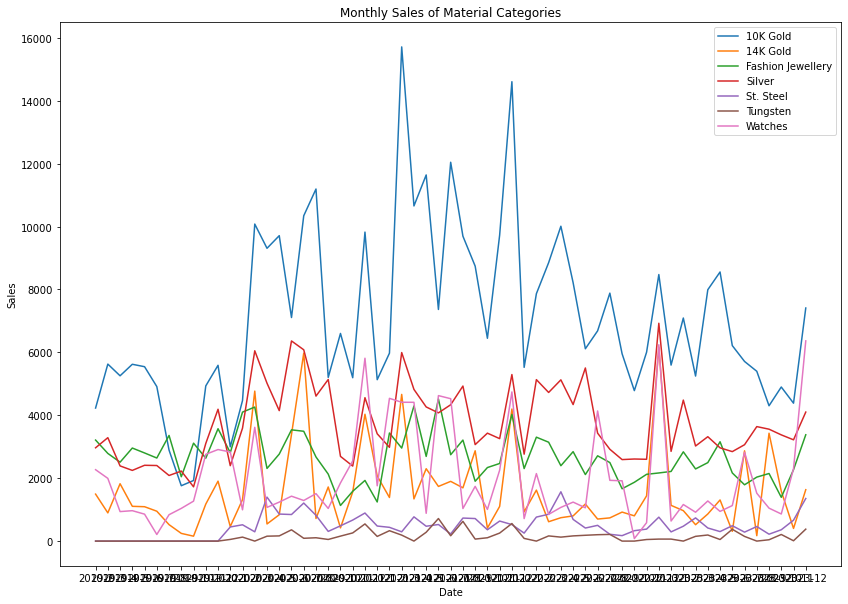

In [73]:
import matplotlib.pyplot as plt

# Convert index to string format
monthly_total_sales.index = monthly_total_sales.index.map(lambda x: '-'.join(map(str, x)))

# Reshape the DataFrame to have separate columns for each material category
material_categories = monthly_total_sales.columns[:-1]

# Plotting all material categories
plt.figure(figsize=(14, 10))

# Loop through each material category
for material in material_categories:
    plt.plot(monthly_total_sales.index, monthly_total_sales[material], label=material)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales of Material Categories')
plt.legend()
plt.show()


# prediction of '10K Gold' for 2024 year

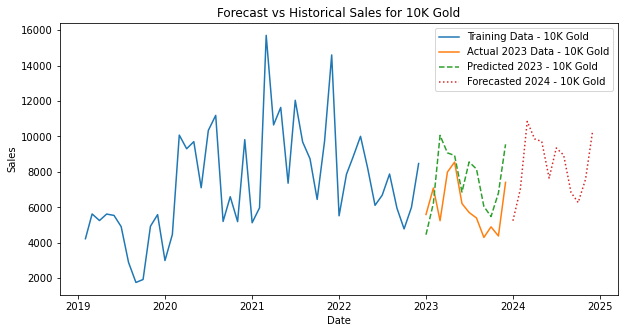

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = '10K Gold'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - 10K Gold')
plt.plot(test.index, test, label='Actual 2023 Data - 10K Gold')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - 10K Gold', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - 10K Gold', linestyle=':')
plt.title(f'Forecast vs Historical Sales for 10K Gold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for 10K Gold in 2023: {r2:.2f}')


In [75]:
forecast_values_2024

2024-01-01     5242.537388
2024-02-01     7020.741484
2024-03-01    10849.642716
2024-04-01     9862.278802
2024-05-01     9717.053422
2024-06-01     7651.264116
2024-07-01     9350.884738
2024-08-01     8948.700244
2024-09-01     6839.224338
2024-10-01     6269.558758
2024-11-01     7591.186658
2024-12-01    10346.100028
Freq: MS, Name: predicted_mean, dtype: float64

In [76]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for 10K Goldimport numpy as np

import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2  # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1 # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 30  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for 10K Gold:", eoq_2024)
print("Safety Stock 2024 for 10K Gold:", safety_stock_2024)
print("Reorder Point 2024 for 10K Gold:", reorder_point_2024)
print("Average Inventory 2024 for 10K Gold:", average_inventory_2024)


EOQ 2024 for 10K Gold: 407.61 units
Safety Stock 2024 for 10K Gold: 116.25 units
Reorder Point 2024 for 10K Gold: 393.16 units
Average Inventory 2024 for 10K Gold: 320.06 units


# prediction of '14K Gold' for 2024 year

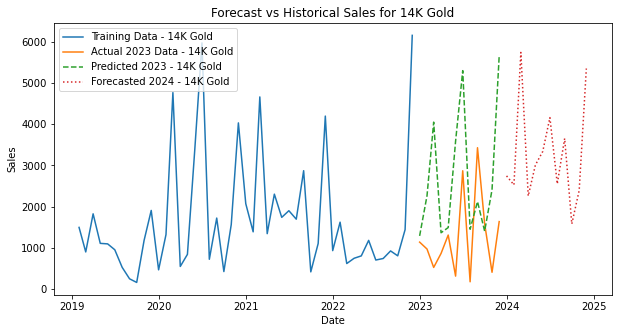

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = '14K Gold'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - 14K Gold')
plt.plot(test.index, test, label='Actual 2023 Data - 14K Gold')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - 14K Gold', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - 14K Gold', linestyle=':')
plt.title(f'Forecast vs Historical Sales for 14K Gold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for 14K Gold in 2023: {r2:.2f}')


In [78]:
forecast_values_2024

2024-01-01    2744.874957
2024-02-01    2525.993341
2024-03-01    5744.128325
2024-04-01    2256.918964
2024-05-01    3008.022177
2024-06-01    3338.382841
2024-07-01    4160.035554
2024-08-01    2550.324836
2024-09-01    3654.027706
2024-10-01    1577.790630
2024-11-01    2392.288600
2024-12-01    5353.186270
Freq: MS, Name: predicted_mean, dtype: float64

In [79]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for 14K Gold

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 35  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for 14K Gold:", eoq_2024)
print("Safety Stock 2024 for 14K Gold:", safety_stock_2024)
print("Reorder Point 2024 for 14K Gold:", reorder_point_2024)
print("Average Inventory 2024 for 14K Gold:", average_inventory_2024)


EOQ 2024 for 14K Gold: 236.96 units
Safety Stock 2024 for 14K Gold: 70.60 units
Reorder Point 2024 for 14K Gold: 164.19 units
Average Inventory 2024 for 14K Gold: 189.08 units


# prediction of 'Fashion Jewellery' for 2024 year

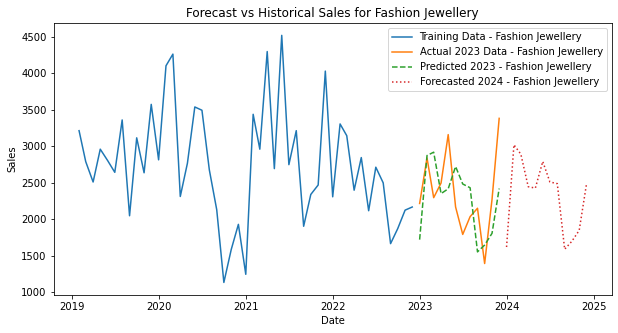

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = 'Fashion Jewellery'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Fashion Jewellery')
plt.plot(test.index, test, label='Actual 2023 Data - Fashion Jewellery')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Fashion Jewellery', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Fashion Jewellery', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Fashion Jewellery')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Fashion Jewellery in 2023: {r2:.2f}')


In [81]:
forecast_values_2024

2024-01-01    1617.446951
2024-02-01    3017.763697
2024-03-01    2889.325939
2024-04-01    2443.749236
2024-05-01    2424.752172
2024-06-01    2789.566698
2024-07-01    2508.248001
2024-08-01    2485.901227
2024-09-01    1586.912261
2024-10-01    1695.327675
2024-11-01    1845.341145
2024-12-01    2466.127513
Freq: MS, Name: predicted_mean, dtype: float64

In [82]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Fashion Jewellery

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2  # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 3 # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Fashion Jewellery:", eoq_2024)
print("Safety Stock 2024 for Fashion Jewellery:", safety_stock_2024)
print("Reorder Point 2024 for Fashion Jewellery:", reorder_point_2024)
print("Average Inventory 2024 for Fashion Jewellery:", average_inventory_2024)


EOQ 2024 for Fashion Jewellery: 680.32 units
Safety Stock 2024 for Fashion Jewellery: 328.93 units
Reorder Point 2024 for Fashion Jewellery: 1100.33 units
Average Inventory 2024 for Fashion Jewellery: 669.09 units


# Prediction of 'Silver' for 2024 year

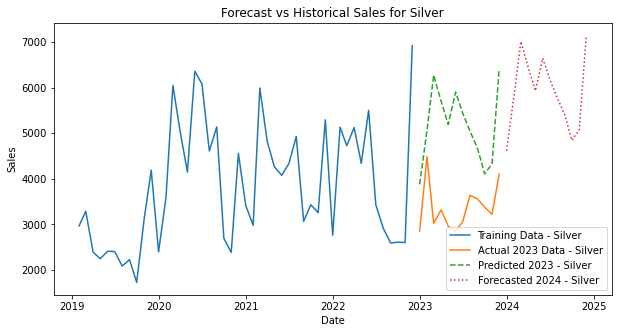

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = 'Silver'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0 ,1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Silver')
plt.plot(test.index, test, label='Actual 2023 Data - Silver')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Silver', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Silver', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Silver')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Silver in 2023: {r2:.2f}')


In [84]:
forecast_values_2024

2024-01-01    4617.702632
2024-02-01    5803.802702
2024-03-01    7013.200757
2024-04-01    6445.506613
2024-05-01    5931.721301
2024-06-01    6644.065045
2024-07-01    6177.021120
2024-08-01    5775.292177
2024-09-01    5411.215152
2024-10-01    4845.691985
2024-11-01    5066.527477
2024-12-01    7147.895784
Freq: MS, Name: predicted_mean, dtype: float64

In [85]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Silver

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"


average_price_per_unit = 2 # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Silver:", eoq_2024)
print("Safety Stock 2024 for Silver:", safety_stock_2024)
print("Reorder Point 2024 for Silver:", reorder_point_2024)
print("Average Inventory 2024 for Silver:", average_inventory_2024)


EOQ 2024 for Silver: 1331.16 units
Safety Stock 2024 for Silver: 805.92 units
Reorder Point 2024 for Silver: 3759.24 units
Average Inventory 2024 for Silver: 1471.50 units


# Prediction of 'St. Steel' for 2024 year

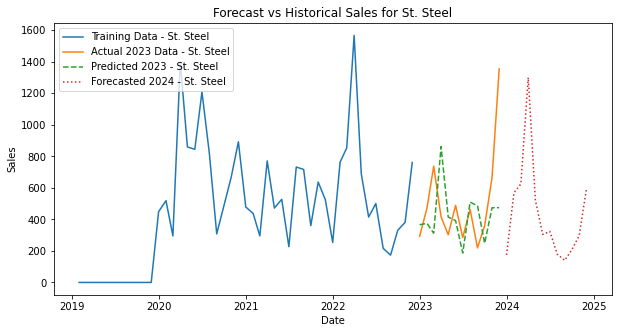

In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = 'St. Steel'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(2,1,0), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - St. Steel')
plt.plot(test.index, test, label='Actual 2023 Data - St. Steel')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - St. Steel', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - St. Steel', linestyle=':')
plt.title(f'Forecast vs Historical Sales for St. Steel')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for St. Steel in 2023: {r2:.2f}')


In [87]:
forecast_values_2024

2024-01-01     174.473530
2024-02-01     568.910665
2024-03-01     624.094020
2024-04-01    1300.095382
2024-05-01     521.322678
2024-06-01     304.709280
2024-07-01     323.379902
2024-08-01     178.706592
2024-09-01     140.024797
2024-10-01     206.627514
2024-11-01     297.386163
2024-12-01     589.992182
Freq: MS, Name: predicted_mean, dtype: float64

In [88]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for St. Steel

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 1  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for St. Steel:", eoq_2024)
print("Safety Stock 2024 for St. Steel:", safety_stock_2024)
print("Reorder Point 2024 for St. Steel:", reorder_point_2024)
print("Average Inventory 2024 for St. Steel:", average_inventory_2024)


EOQ 2024 for St. Steel: 511.36 units
Safety Stock 2024 for St. Steel: 635.01 units
Reorder Point 2024 for St. Steel: 1070.82 units
Average Inventory 2024 for St. Steel: 890.69 units


# Prediction of 'Tungsten' for 2024 year

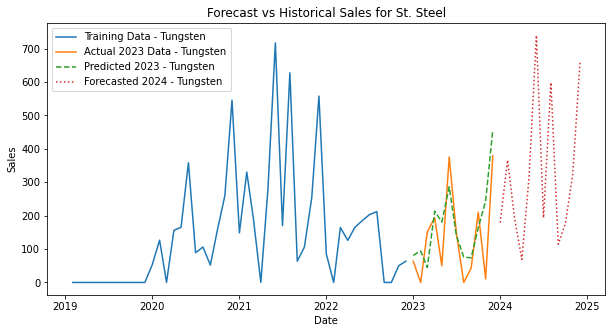

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = 'Tungsten'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0,1,1), seasonal_order=(2, 1,0, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Tungsten')
plt.plot(test.index, test, label='Actual 2023 Data - Tungsten')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Tungsten', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Tungsten', linestyle=':')
plt.title(f'Forecast vs Historical Sales for St. Steel')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Tungsten in 2023: {r2:.2f}')


In [90]:
forecast_values_2024

2024-01-01    179.497237
2024-02-01    366.275486
2024-03-01    194.363136
2024-04-01     68.883686
2024-05-01    313.339696
2024-06-01    739.523438
2024-07-01    193.465398
2024-08-01    598.117347
2024-09-01    114.553313
2024-10-01    176.866453
2024-11-01    326.021302
2024-12-01    658.103957
Freq: MS, Name: predicted_mean, dtype: float64

In [91]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Tungsten

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1 # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 2 # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Tungsten:", eoq_2024)
print("Safety Stock 2024 for Tungsten:", safety_stock_2024)
print("Reorder Point 2024 for Tungsten:", reorder_point_2024)
print("Average Inventory 2024 for Tungsten:", average_inventory_2024)


EOQ 2024 for Tungsten: 313.41 units
Safety Stock 2024 for Tungsten: 218.44 units
Reorder Point 2024 for Tungsten: 382.15 units
Average Inventory 2024 for Tungsten: 375.14 units


# Prediction of 'Watches' for 2024 year

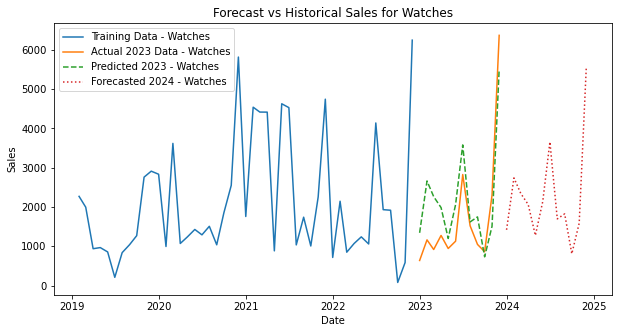

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

material = 'Watches'
sales_data = monthly_total_sales[material]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Watches')
plt.plot(test.index, test, label='Actual 2023 Data - Watches')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Watches', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Watches', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Watches')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Watches in 2023: {r2:.2f}')


In [93]:
forecast_values_2024

2024-01-01    1419.328560
2024-02-01    2738.680628
2024-03-01    2340.368735
2024-04-01    2060.897152
2024-05-01    1275.904524
2024-06-01    2138.952377
2024-07-01    3655.234028
2024-08-01    1696.327119
2024-09-01    1824.056503
2024-10-01     808.429215
2024-11-01    1585.819624
2024-12-01    5578.591316
Freq: MS, Name: predicted_mean, dtype: float64

In [94]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Watches

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2  # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1 # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 200  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Watches:", eoq_2024)
print("Safety Stock 2024 for Watches:", safety_stock_2024)
print("Reorder Point 2024 for Watches:", reorder_point_2024)
print("Average Inventory 2024 for Watches:", average_inventory_2024)


EOQ 2024 for Watches: 82.34 units
Safety Stock 2024 for Watches: 12.53 units
Reorder Point 2024 for Watches: 23.83 units
Average Inventory 2024 for Watches: 53.70 units


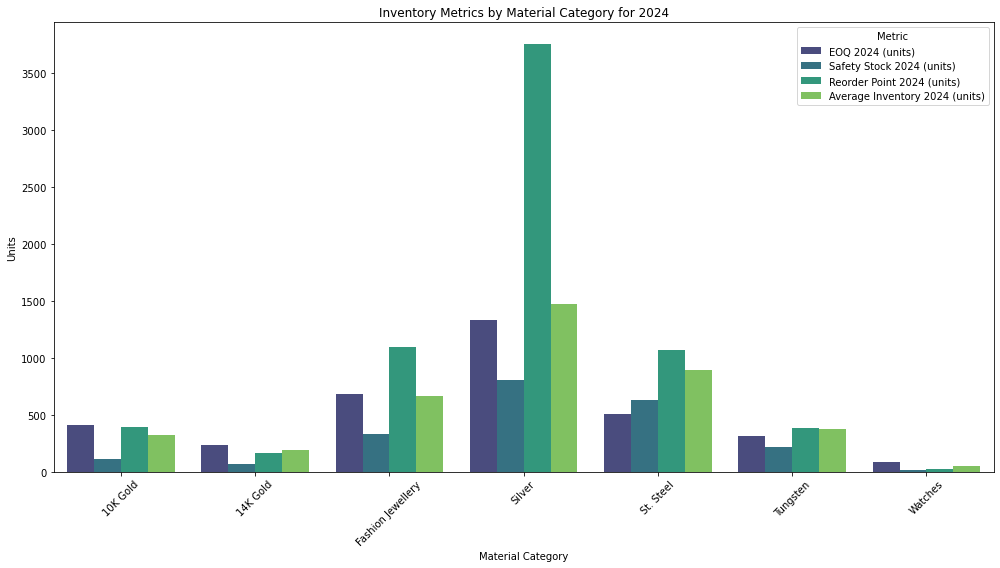

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame with the given data
data = {
    "Material Category": ["10K Gold", "14K Gold", "Fashion Jewellery", "Silver", "St. Steel", "Tungsten", "Watches"],
    "EOQ 2024 (units)": [407.61, 236.96, 680.32, 1331.16, 511.36, 313.41, 82.34],
    "Safety Stock 2024 (units)": [116.25, 70.60, 328.93, 805.92, 635.01, 218.44, 12.53],
    "Reorder Point 2024 (units)": [393.16, 164.19, 1100.33, 3759.24, 1070.82, 382.15, 23.83],
    "Average Inventory 2024 (units)": [320.06, 189.08, 669.09, 1471.50, 890.69, 375.14, 53.70]
}
inventory_df = pd.DataFrame(data)

# Melt the DataFrame to make it suitable for seaborn's barplot
inventory_melted = inventory_df.melt(id_vars="Material Category", var_name="Metric", value_name="Units")

# Create a grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Material Category', y='Units', hue='Metric', data=inventory_melted, palette='viridis')
plt.title('Inventory Metrics by Material Category for 2024')
plt.xlabel('Material Category')
plt.ylabel('Units')
plt.xticks(rotation=45)
plt.legend(title='Metric')

plt.tight_layout()
plt.show()


# Model for predicting Item_Categories for 2024 year

In [96]:
pivot_item_monthly_sales

Item Category,Date,Anklet,Bracelet,Chain,Chain & Charm,Charm,Custom items,Earring,Fashion Jewellery,Hoops,Nose Ring,Ring,Studs,Watch
0,2019-02-01,0.0,57.00,0.00,120.000,177.350,344.500000,70.000,0.0,0.0,0,112.50,0.00,0.0
1,2019-02-02,0.0,182.34,207.06,329.300,220.045,10.000000,67.800,0.0,0.0,0,147.40,0.00,0.0
2,2019-02-03,0.0,0.00,16.00,58.300,82.500,0.000000,131.365,0.0,0.0,0,0.00,0.00,0.0
3,2019-02-04,0.0,0.00,627.00,353.695,90.000,0.000000,40.000,0.0,0.0,0,100.70,0.00,0.0
4,2019-02-05,0.0,0.00,0.00,0.000,0.000,79.000000,30.000,0.0,0.0,0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2023-12-27,0.0,0.00,51.94,234.300,0.000,179.500000,0.000,0.0,0.0,0,104.40,25.00,0.0
1748,2023-12-28,0.0,0.00,0.00,0.000,0.000,0.000000,0.000,0.0,0.0,0,0.00,0.00,153.0
1749,2023-12-29,0.0,68.90,302.10,0.000,188.900,200.000000,0.000,0.0,0.0,0,165.27,83.74,142.0
1750,2023-12-30,87.0,0.00,211.05,280.900,85.000,54.033333,0.000,0.0,105.0,0,159.00,0.00,170.0


In [97]:
pivot_item_monthly_sales.set_index('Date', inplace=True)

# Feature Engineering
pivot_item_monthly_sales['Month'] = pivot_item_monthly_sales.index.month
pivot_item_monthly_sales['Year'] = pivot_item_monthly_sales.index.year
pivot_item_monthly_sales['Day_of_Week'] = pivot_item_monthly_sales.index.dayofweek

pivot_item_monthly_sales

Item Category,Anklet,Bracelet,Chain,Chain & Charm,Charm,Custom items,Earring,Fashion Jewellery,Hoops,Nose Ring,Ring,Studs,Watch,Month,Year,Day_of_Week
Date,,,,,,,,,,,,,,,,
2019-02-01,0.0,57.00,0.00,120.000,177.350,344.500000,70.000,0.0,0.0,0,112.50,0.00,0.0,2,2019,4
2019-02-02,0.0,182.34,207.06,329.300,220.045,10.000000,67.800,0.0,0.0,0,147.40,0.00,0.0,2,2019,5
2019-02-03,0.0,0.00,16.00,58.300,82.500,0.000000,131.365,0.0,0.0,0,0.00,0.00,0.0,2,2019,6
2019-02-04,0.0,0.00,627.00,353.695,90.000,0.000000,40.000,0.0,0.0,0,100.70,0.00,0.0,2,2019,0
2019-02-05,0.0,0.00,0.00,0.000,0.000,79.000000,30.000,0.0,0.0,0,0.00,0.00,0.0,2,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,0.00,51.94,234.300,0.000,179.500000,0.000,0.0,0.0,0,104.40,25.00,0.0,12,2023,2
2023-12-28,0.0,0.00,0.00,0.000,0.000,0.000000,0.000,0.0,0.0,0,0.00,0.00,153.0,12,2023,3
2023-12-29,0.0,68.90,302.10,0.000,188.900,200.000000,0.000,0.0,0.0,0,165.27,83.74,142.0,12,2023,4


In [98]:
# Aggregate total sales for each material category per month
monthly_total_sales = pivot_item_monthly_sales.groupby(['Year', 'Month']).sum()

monthly_total_sales

Item Category  Anklet     Bracelet         Chain  Chain & Charm        Charm  \
Year Month                                                                     
2019 2           0.00  1142.075000   2521.251667    3763.626667  2001.675000   
     3           0.00  1781.240000   3097.205000    5323.641667  1908.635000   
     4           0.00   789.566667   3879.015000    4842.076667  1235.840000   
     5         191.29  1932.968333   3710.411667    4611.070000  1255.420000   
     6          30.00  1052.840000   2397.890000    4965.291667  1278.085000   
     7         127.20  1423.300000   3605.830000    4583.060000   338.800000   
     8          98.40   468.600000   3138.361667    3305.313333  1232.100000   
     9          25.00   629.900000   2427.803333    3272.090000   498.995000   
     10          0.00   271.000000   2080.361667    2159.865000   753.490000   
     11          0.00  2214.300000   3387.982500    3488.813333  2111.616667   
     12          0.00  2169.965000   3933.937500    6551.681667  2683.345000   
2020 1           0.00   520.240000   1858.205000    2354.016667   807.840000   
     2           0.00  1062.230000   3745.553333    5445.863333  1303.055000   
     3          95.00  2861.100000   9021.236667   10819.991667  3121.550000   
     4          53.00  1464.300000   5412.013333    5067.810000  3628.375000   
     5         153.70  1856.250000   6393.466667    7991.446667  1853.270000   
     6           0.00  2801.528333   6493.585000    7309.018333  2845.910000   
     7          68.90  3290.910000   5085.898333   10532.775833  3204.880000   
     8           0.00  1616.550000   4866.313333    6701.323333  2019.420000   
     9           0.00  2224.040000   3917.693333    6297.183333   542.390000   
     10         53.00   916.150000   3374.068333    4865.620000   447.200000   
     11          0.00   824.256667   3014.030000    3622.236667  1702.960000   
     12          0.00  3175.218333   5172.201667    7177.196667  1934.658333   
2021 1           0.00  1419.040000   1951.500000    3488.440000  1239.250000   
     2           0.00  1845.230000   5098.685000    4262.550000  2790.883333   
     3           0.00  4728.395000  10695.810000   11780.790000  4818.440000   
     4           0.00  2386.155000   5504.186667    7563.735000  3451.480000   
     5         258.64  4685.903333   7475.425000    6822.880000  4214.516667   
     6         279.50  2869.830000   8166.508333    6243.663333  3803.460000   
     7         168.90  2870.220000   5923.638333    5550.655000  4116.750000   
     8         100.00  2204.660000   4357.655000    8442.270000  3481.115000   
     9           0.00  4799.943333   7585.666667    4832.610000  1785.070000   
     10        211.90  1632.970000   2668.726667    4471.600000  2206.880000   
     11          0.00  2841.570000   4239.458333    8194.530000  1076.600000   
     12        475.70  5376.165000  10334.345000   11942.118333  6841.171667   
2022 1           0.00  1032.000000   3207.778333    1904.090000  1608.425000   
     2          63.40  2794.465000   4949.053333    4425.343333  3278.000000   
     3           0.00  1120.633333   7064.715000    5876.610000  2070.570000   
     4          53.00  1909.500000   7264.013333    4369.356667  3507.875000   
     5         153.70  1411.050000   3697.166667    7554.080000  1873.770000   
     6           0.00  1320.150000   5155.390000    7880.950000  2582.000000   
     7         111.30  1992.900000   6579.230000    3315.980000  2120.680000   
     8          53.00  4669.920000   3828.360000    6315.075000  4199.455000   
     9          40.00   573.150000   3710.780000    1748.590000  1828.840000   
     10        153.17  1328.250000   2338.100000    1743.133333  1475.826667   
     11          0.00  1360.650000   3762.480000    3216.273333  3024.990000   
     12        110.00  3455.133333  10887.445000    7927.443000  5333.285000   
2023 1           0.00   490.680000   1375.850000    3499.500000  1562.300000   


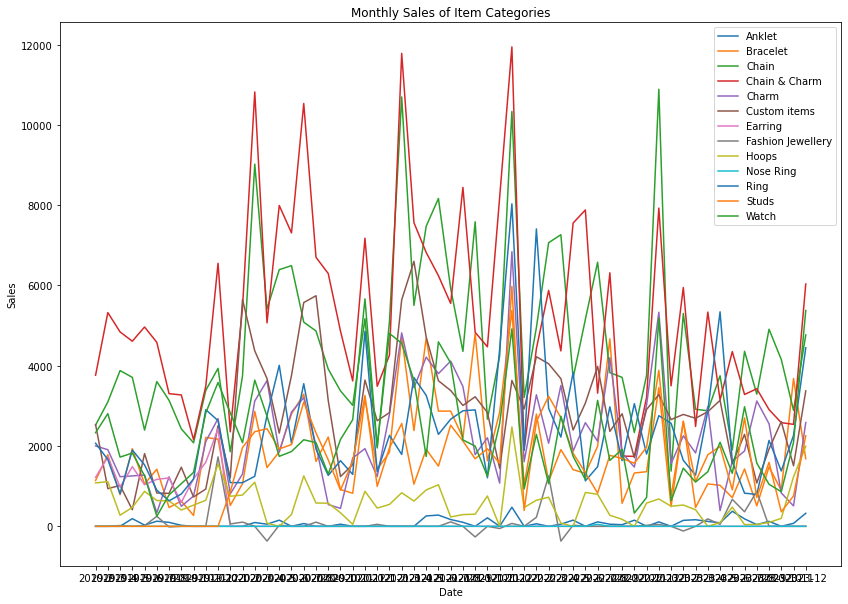

In [99]:
import matplotlib.pyplot as plt

# Convert index to string format
monthly_total_sales.index = monthly_total_sales.index.map(lambda x: '-'.join(map(str, x)))

# Reshape the DataFrame to have separate columns for each material category
Item_categories = monthly_total_sales.columns[:-1]

# Plotting all material categories
plt.figure(figsize=(14, 10))

# Loop through each material category
for Item in Item_categories:
    plt.plot(monthly_total_sales.index, monthly_total_sales[Item], label=Item)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales of Item Categories')
plt.legend()
plt.show()


# prediction of 'Chain & Charm' for 2024 year

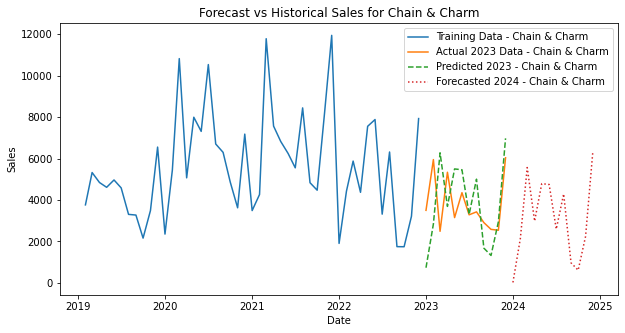

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

Item = 'Chain & Charm'
sales_data = monthly_total_sales[Item]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Chain & Charm')
plt.plot(test.index, test, label='Actual 2023 Data - Chain & Charm')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Chain & Charm', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Chain & Charm', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Chain & Charm')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for 10K Gold in 2023: {r2:.2f}')


In [101]:
forecast_values_2024

2024-01-01      21.058550
2024-02-01    2128.056742
2024-03-01    5564.685980
2024-04-01    2979.157980
2024-05-01    4787.084393
2024-06-01    4747.514566
2024-07-01    2593.776257
2024-08-01    4292.763357
2024-09-01     966.382312
2024-10-01     612.337647
2024-11-01    2242.898696
2024-12-01    6262.669476
Freq: MS, Name: predicted_mean, dtype: float64

In [102]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for 10K Gold

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2  # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1 # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 50 # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit


# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Chain & Charm:", eoq_2024)
print("Safety Stock 2024 for Chain & Charm:", safety_stock_2024)
print("Reorder Point 2024 for Chain & Charm:", reorder_point_2024)
print("Average Inventory 2024 for Chain & Charm:", average_inventory_2024)


EOQ 2024 for Chain & Charm: 192.87 units
Safety Stock 2024 for Chain & Charm: 79.49 units
Reorder Point 2024 for Chain & Charm: 141.49 units
Average Inventory 2024 for Chain & Charm: 175.93 units


# prediction of 'Chain' for 2024 year

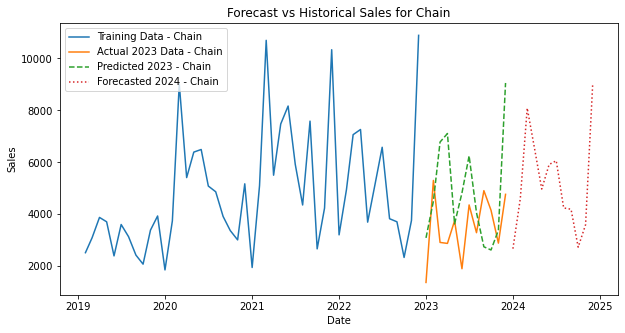

In [103]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

Item = 'Chain'
sales_data = monthly_total_sales[Item]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Chain')
plt.plot(test.index, test, label='Actual 2023 Data - Chain')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Chain', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Chain', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Chain')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for 14K Gold in 2023: {r2:.2f}')


In [104]:
forecast_values_2024

2024-01-01    2676.397804
2024-02-01    4605.271544
2024-03-01    8086.727275
2024-04-01    6520.476042
2024-05-01    4972.150114
2024-06-01    5916.278147
2024-07-01    6061.602063
2024-08-01    4244.434327
2024-09-01    4193.672351
2024-10-01    2733.673528
2024-11-01    3597.981042
2024-12-01    9020.321596
Freq: MS, Name: predicted_mean, dtype: float64

In [105]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Chain

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 25  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Chain:", eoq_2024)
print("Safety Stock 2024 for Chain:", safety_stock_2024)
print("Reorder Point 2024 for Chain:", reorder_point_2024)
print("Average Inventory 2024 for Chain:", average_inventory_2024)


EOQ 2024 for Chain: 353.92 units
Safety Stock 2024 for Chain: 155.50 units
Reorder Point 2024 for Chain: 364.26 units
Average Inventory 2024 for Chain: 332.46 units


# prediction of 'Charm' for 2024 year

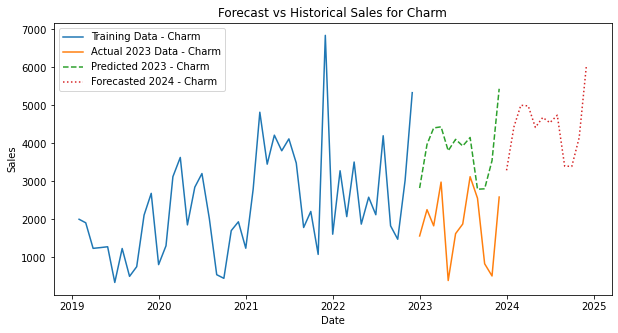

In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

Item = 'Charm'
sales_data = monthly_total_sales[Item]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Charm')
plt.plot(test.index, test, label='Actual 2023 Data - Charm')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Charm', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Charm', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Charm')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Charm in 2023: {r2:.2f}')


In [107]:
forecast_values_2024

2024-01-01    3289.568735
2024-02-01    4433.664145
2024-03-01    5001.407152
2024-04-01    4984.625506
2024-05-01    4419.237216
2024-06-01    4680.502241
2024-07-01    4542.766420
2024-08-01    4739.672122
2024-09-01    3400.426392
2024-10-01    3393.801712
2024-11-01    4150.142976
2024-12-01    6029.103214
Freq: MS, Name: predicted_mean, dtype: float64

In [108]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Fashion Jewellery

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2  # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 15  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Charm:", eoq_2024)
print("Safety Stock 2024 for Charm:", safety_stock_2024)
print("Reorder Point 2024 for Charm:", reorder_point_2024)
print("Average Inventory 2024 for Charm:", average_inventory_2024)


EOQ 2024 for Charm: 420.57 units
Safety Stock 2024 for Charm: 103.30 units
Reorder Point 2024 for Charm: 398.11 units
Average Inventory 2024 for Charm: 313.58 units


# Prediction of 'Bracelet' for 2024 year

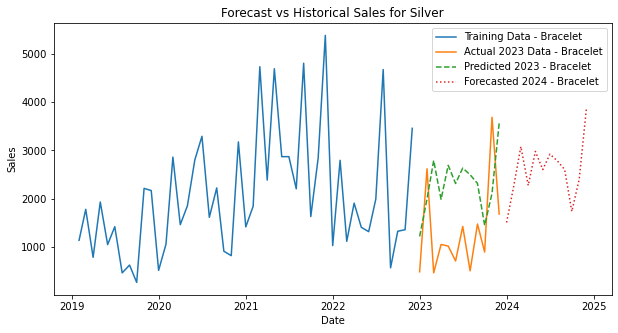

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

Item = 'Bracelet'
sales_data = monthly_total_sales[Item]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0 ,1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Bracelet')
plt.plot(test.index, test, label='Actual 2023 Data - Bracelet')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Bracelet', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Bracelet', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Silver')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Bracelet in 2023: {r2:.2f}')


In [110]:
forecast_values_2024

2024-01-01    1509.236536
2024-02-01    2281.207612
2024-03-01    3078.607391
2024-04-01    2275.159318
2024-05-01    2978.769867
2024-06-01    2603.161616
2024-07-01    2922.096138
2024-08-01    2783.552617
2024-09-01    2603.507969
2024-10-01    1737.982513
2024-11-01    2401.491734
2024-12-01    3850.294374
Freq: MS, Name: predicted_mean, dtype: float64

In [111]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Silver

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 200  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Bracelet:", eoq_2024)
print("Safety Stock 2024 for Bracelet:", safety_stock_2024)
print("Reorder Point 2024 for Bracelet:", reorder_point_2024)
print("Average Inventory 2024 for Bracelet", average_inventory_2024)


EOQ 2024 for Bracelet: 88.07 units
Safety Stock 2024 for Bracelet: 6.09 units
Reorder Point 2024 for Bracelet: 19.02 units
Average Inventory 2024 for Bracelet 50.12 units


# Prediction of 'Studs' for 2024 year

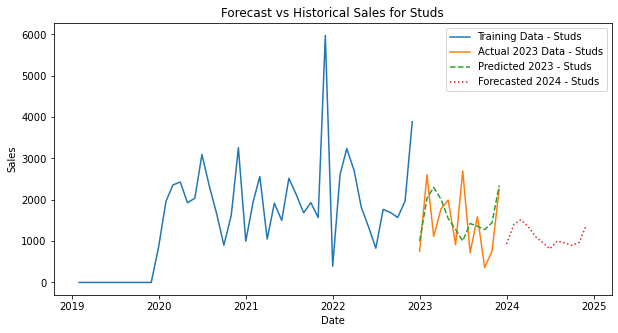

In [126]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

Item = 'Studs'
sales_data = monthly_total_sales[Item]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Studs')
plt.plot(test.index, test, label='Actual 2023 Data - Studs')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Studs', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Studs', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Studs')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Studs in 2023: {r2:.2f}')


In [127]:
forecast_values_2024

2024-01-01     930.374626
2024-02-01    1407.239345
2024-03-01    1514.582315
2024-04-01    1353.155450
2024-05-01    1110.473508
2024-06-01     964.056516
2024-07-01     812.936983
2024-08-01    1002.326685
2024-09-01     954.999643
2024-10-01     899.839962
2024-11-01     967.110103
2024-12-01    1390.002203
Freq: MS, Name: predicted_mean, dtype: float64

In [128]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for St. Steel

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2 # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1  # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 20  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Studs:", eoq_2024)
print("Safety Stock 2024 for Studs:", safety_stock_2024)
print("Reorder Point 2024 for Studs:", reorder_point_2024)
print("Average Inventory 2024 for Studs:", average_inventory_2024)


EOQ 2024 for Studs: 182.39 units
Safety Stock 2024 for Studs: 23.48 units
Reorder Point 2024 for Studs: 78.93 units
Average Inventory 2024 for Studs: 114.67 units


# Prediction of 'Hoops' for 2024 year

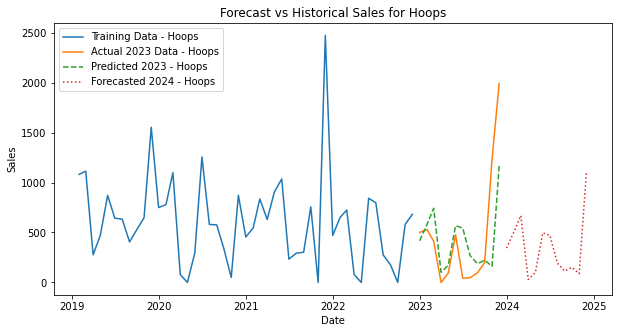

In [118]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load your data and ensure it's indexed by date
# monthly_total_sales = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# Assuming 'monthly_total_sales' is loaded correctly and has the correct datetime index
monthly_total_sales.index = pd.to_datetime(monthly_total_sales.index)
monthly_total_sales.index = monthly_total_sales.index.tz_localize(None)

Item = 'Hoops'
sales_data = monthly_total_sales[Item]

# Split data into training and test sets
train = sales_data[:'2022']  # Data up to the end of 2022
test = sales_data['2023']    # Data for 2023

# Define and fit the SARIMA model on the training data
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for 2023
forecast_2023 = model_fit.get_forecast(steps=12)
forecast_values_2023 = forecast_2023.predicted_mean

# Calculate R^2 value for 2023
r2 = r2_score(test, forecast_values_2023)

# Forecast for 2024 using the model fitted on data up to 2022
forecast_2024 = model_fit.get_forecast(steps=24)
forecast_values_2024 = forecast_2024.predicted_mean['2024']

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data - Hoops')
plt.plot(test.index, test, label='Actual 2023 Data - Hoops')
plt.plot(forecast_values_2023.index, forecast_values_2023, label='Predicted 2023 - Hoops', linestyle='--')
plt.plot(forecast_values_2024.index, forecast_values_2024, label='Forecasted 2024 - Hoops', linestyle=':')
plt.title(f'Forecast vs Historical Sales for Hoops')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#print(f'R^2 for Hoops in 2023: {r2:.2f}')


In [119]:
forecast_values_2024

2024-01-01     343.807753
2024-02-01     507.551744
2024-03-01     669.186374
2024-04-01      29.222562
2024-05-01      98.519973
2024-06-01     495.810077
2024-07-01     470.777780
2024-08-01     195.783288
2024-09-01     113.815018
2024-10-01     150.767765
2024-11-01      88.187709
2024-12-01    1094.290360
Freq: MS, Name: predicted_mean, dtype: float64

In [120]:
## Calculating : Economic Order Quantity (EOQ), Reorder point, Safety Stock,Average Inventory for Watches

import numpy as np
import pandas as pd

# Define parameters (example values; you need to set these based on your actual data and costs)
order_cost = 50  # Fixed cost per order, assuming the same for all categories (USD)
holding_cost_per_unit_per_month = 2  # Holding cost per unit per month (USD per unit per month)
lead_time_in_months = 1 # Lead time in months (months)
confidence_level_z = 1.96  # Z-score for 95% confidence interval (dimensionless)

# Assuming 'forecast_values_2024' is preloaded with your 2024 forecast data

# Calculate EOQ for each category
def calculate_eoq(demand, order_cost, holding_cost):
    eoq = np.sqrt((2 * demand * order_cost) / holding_cost)
    return f"{eoq:.2f} units"  # Units appended as part of the string

# Calculate reorder point
def calculate_reorder_point(monthly_demand, lead_time, safety_stock):
    reorder_point = monthly_demand * lead_time + float(safety_stock.split()[0])  # Extract numerical value from string
    return f"{reorder_point:.2f} units"

# Calculate safety stock based on standard deviation of demand
def calculate_safety_stock(demand_std_dev, lead_time, z_value):
    safety_stock = demand_std_dev * np.sqrt(lead_time) * z_value
    return f"{safety_stock:.2f} units"

# Calculate average inventory required
def calculate_average_inventory(eoq, safety_stock):
    average_inventory = float(eoq.split()[0]) / 2 + float(safety_stock.split()[0])  # Extract numerical values from strings
    return f"{average_inventory:.2f} units"

average_price_per_unit = 25  # Example price per unit
forecast_values_2024 = forecast_values_2024 / average_price_per_unit

# Calculate annual demand from monthly forecast data
annual_demand_2024 = forecast_values_2024.sum()

# Standard deviation of monthly demand (forecast data)
monthly_demand_std_dev_2024 = forecast_values_2024.std()

# Average monthly demand (for reorder point calculations)
average_monthly_demand_2024 = forecast_values_2024.mean()

# Calculations
eoq_2024 = calculate_eoq(annual_demand_2024, order_cost, holding_cost_per_unit_per_month)
safety_stock_2024 = calculate_safety_stock(monthly_demand_std_dev_2024, lead_time_in_months, confidence_level_z)
reorder_point_2024 = calculate_reorder_point(average_monthly_demand_2024, lead_time_in_months, safety_stock_2024)
average_inventory_2024 = calculate_average_inventory(eoq_2024, safety_stock_2024)

# Print the results
print("EOQ 2024 for Hoops:", eoq_2024)
print("Safety Stock 2024 for Hoops:", safety_stock_2024)
print("Reorder Point 2024 for Hoops:", reorder_point_2024)
print("Average Inventory 2024 for Hoops:", average_inventory_2024)


EOQ 2024 for Hoops: 92.28 units
Safety Stock 2024 for Hoops: 24.45 units
Reorder Point 2024 for Hoops: 38.64 units
Average Inventory 2024 for Hoops: 70.59 units


In [121]:
#Plot

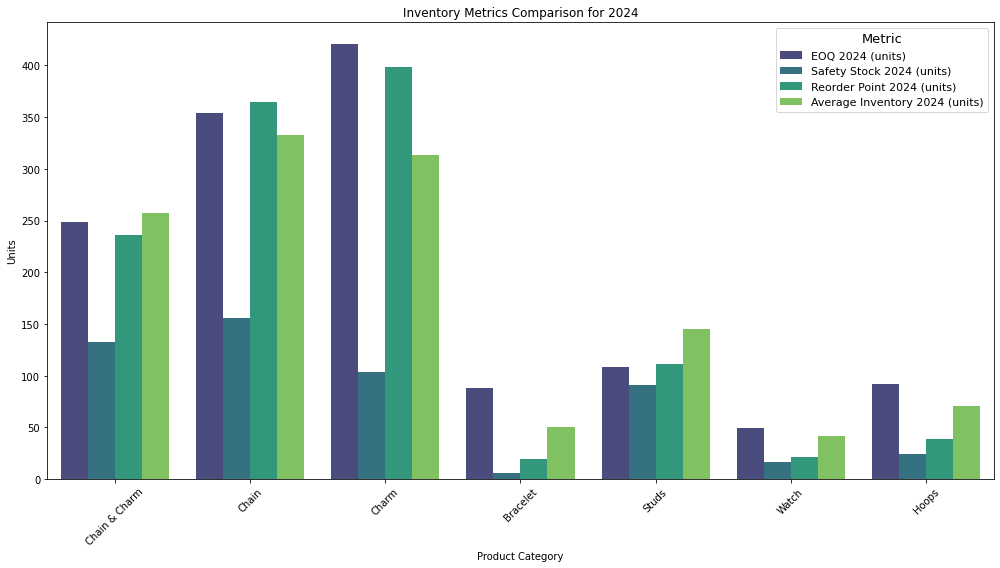

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    "Product Category": ["Chain & Charm", "Chain", "Charm", "Bracelet", "Studs", "Watch", "Hoops"],
    "EOQ 2024 (units)": [248.99, 353.92, 420.57, 88.07, 108.65, 49.64, 92.28],
    "Safety Stock 2024 (units)": [132.48, 155.50, 103.30, 6.09, 91.19, 16.93, 24.45],
    "Reorder Point 2024 (units)": [235.81, 364.26, 398.11, 19.02, 110.87, 21.04, 38.64],
    "Average Inventory 2024 (units)": [256.98, 332.46, 313.58, 50.12, 145.51, 41.75, 70.59]
}

# Create the DataFrame
inventory_df = pd.DataFrame(data)

# Melt the DataFrame to make it suitable for seaborn's barplot
inventory_melted = inventory_df.melt(id_vars=["Product Category"], var_name="Metric", value_name="Units")

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x="Product Category", y="Units", hue="Metric", data=inventory_melted, palette="viridis")
plt.title("Inventory Metrics Comparison for 2024")
plt.ylabel("Units")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.legend(title="Metric", title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()
